In [1]:
### Import libraries and set plot style

import numpy as np
from scipy.optimize import curve_fit
from os import listdir
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
colors = ['#202020', '#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#bcbd22', '#e377c2', '#17becf', '#1f5a0a', '#8c564b', '#7f7f7f']
         ## black    red        blue       green      orange     violet     yellow     pink       lightblue  darkgreen  dirty-red  grey
plt.rcParams.update({'font.size': 15.5,
                     'axes.titlepad': 25,
                     'axes.labelpad': 20,
                     'axes.labelsize': 20,
                     'xtick.labelsize' : 15.5,
                     'ytick.labelsize' : 15.5,
                     'axes.prop_cycle': cycler('color', colors),
                     #'axes.grid': True,
                     'axes.linewidth': 0.5,
                     'lines.linewidth': 1.5,
                     'lines.markersize': 5,
                     'scatter.marker': 'o',
                     #'errorbar.capsize': 2,
                     'figure.dpi': 100.0,
                     'figure.figsize': [8, 5],
                     'xtick.top' : True,
                     'ytick.right' : True,
                     'xtick.direction' : 'out',
                     'ytick.direction' : 'out',
                     'xtick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.major.size': 8,
                     'ytick.minor.size': 4,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.5,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.5})

In [2]:
### Import raw data and define measurement specifications

SAMPLE = "20-PEI"
SAMPLE_SHORT = SAMPLE[:2]
# specify what temperatures where used and in what order
TEMPS = [70, 50, 30]
GASES = ["N$_2$", "CO$_2$"]
# specify which gas is used in which run: N_2 -> 0, CO_2 -> 1 (specified in "GASES")
# rows: measurements with fixed temperature, same order as "TEMPS" above
# columns: runs
# (compatability) the same gas may be used twice in a row
S = [[1, 0, 1, 0],
     [1, 0, 1, 0],
     [0, 1, 0, 1, 0]]
# ignore these runs: unusable / redundant data
id_out = ["50-0"]
# specify the starting times of the runs
# sometimes the measurement doesn't start at t=0: set GASCHANGE[0] to cut out degassing phase, otherwise set 0 as first value
# After that, put time in seconds for every time the gas is changed (or new ballon with same gas)
GASCHANGE = [[0, 6989, 16205, 25988],
             [1.8848e+04, 19289, 25645, 33843],
             [7.0136e+03, 10697, 18196, 25623, 32600]]
# columns (indices) of frequency, epsilon' (er), epsilon'' (ei) and time in ascii file
f_col, er_col, ei_col, t_col = 0, 2, 3, -1

# specify folder and filenames of raw data, files in same order as "TEMPS" above
folder = "raw data PEI20/"
files = ["13-10_M2_TBD031_PEI20_70C_CNCN.TXT",
         "13-13_M1_TBD031_PEI20_50C_NdryCNCN.TXT",
         "13-14_M2_TBD031_PEI20_30C_NdryCNCN.TXT"]
DATA = [[], [], []]

for m, f in enumerate(files) :
     # import ascii data, usually it has a header of 4 lines that is cut out
     data_ = np.genfromtxt(folder+f, delimiter='\t', skip_header=4)

     # remove points before start of first run
     after = data_[:,-1] >= GASCHANGE[m][0]
     data = data_[after]

     # add final time to GASCHANGE, needed in main and make time unit hours
     GASCHANGE[m].append(data[-1,-1])
     GASCHANGE[m] = np.array(GASCHANGE[m]) / 60.
     data[:,-1] = data[:,-1] / 60.

     DATA[m] = data

In [3]:
### Data processing

def gradient_matrix(y, x) :
    # y is a 2D array of shape (m,n) and x a vector of shape m
    # froms forward gradient of every column of y along x
    # returns matrix of shape (m-1,n)
    return (y[1:, :] - y[:-1, :]) / (x[1:] - x[:-1])[:, np.newaxis]
    

f_out = [5e5] # ignore data of these frequencies
def extract_interpolate_and_derivative(data, num_points=0):
    """
    Extracts lists x_k for every measured data x at a fixed frequency k
    Creates a universal test set of time points
    Interpolates every fixed-frequency data set for those time points
    Computes derivative epsilon'_der along frequency axis
    """
    
    # Extract unique F_k values
    # ignore frequencies specified in f_out
    unique_f = np.unique(data[:, f_col])
    mask = ~np.isin(unique_f, f_out)
    unique_f = unique_f[mask]
    lnw = np.log(2*np.pi*unique_f)  # Compute ln(omega)
    
    # find time boundaries of data
    # and generate `num_points` equidistant t_i values
    initial_test_t, final_test_t = -np.inf, np.inf
    for f_k in unique_f :
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        initial_test_t = max(initial_test_t, np.min(t_k))
        final_test_t = min(final_test_t, np.max(t_k))
    if not num_points:
        num_points = int((final_test_t - initial_test_t) *2)
        
    t_test_set = np.linspace(0, final_test_t, num_points)

    # er: real part of epsilon; ei: imag. part; t: corresponding measured time
    er_int, ei_int = [], []
    # Group er_k and ei_k based on unique F_k
    # unify to test times by interpolation
    for f_k in unique_f:
        mask = data[:, 0] == f_k
        t_k = data[mask][:, t_col]
        er_k = data[mask][:, er_col]
        ei_k = data[mask][:, ei_col]

        er_int_k = np.interp(t_test_set, t_k, er_k, left=np.nan, right=np.nan)
        ei_int_k = np.interp(t_test_set, t_k, ei_k, left=np.nan, right=np.nan)
        
        er_int.append(er_int_k)
        ei_int.append(ei_int_k)

    er_int = np.array(er_int)
    ei_int = np.array(ei_int)


    # Compute gradient of er_k along ln(F)
    er_der =  -np.pi/2 * gradient_matrix(er_int, lnw)
    #er_der =  -np.pi/2 * np.gradient(er_int, lnw, axis=0)

    return unique_f, er_der.T, ei_int.T, t_test_set


def score(popt, pcov, y_data, f_data):
    """
    Computes a fit quality score based on R^2, reduced chi-square, AIC, BIC, and parameter covariances.

    Parameters:
        popt (np.ndarray): Optimized fit parameters from curve_fit.
        pcov (np.ndarray): Covariance matrix of fit parameters from curve_fit.
        y_data (np.ndarray): Measured values.
        f_data (np.ndarray): Fitted values.

    Returns:
        float: Fit quality score (higher is better).
    """
    N = len(y_data)  # Number of data points
    p = len(popt)    # Number of fit parameters
    dof = max(N - p, 1)  # Degrees of freedom (avoid division by zero)

    # Residuals
    residuals = y_data - f_data
    RSS = np.sum(residuals**2)  # Residual sum of squares
    TSS = np.sum((y_data - np.mean(y_data))**2)  # Total sum of squares

    # Coefficient of determination (R^2)
    r_squared = 1 - (RSS / TSS) if TSS > 0 else 0

    # Reduced chi-square (if assuming equal variance in y)
    chi_sq_red = RSS / dof

    # Akaike Information Criterion (AIC)
    aic = 2 * p + N * np.log(RSS / N)

    # Bayesian Information Criterion (BIC)
    bic = p * np.log(N) + N * np.log(RSS / N)

    # Covariance penalty: Large covariance values indicate poorly constrained parameters
    cov_trace = np.trace(pcov) if pcov is not None else 0
    cov_score = np.exp(-np.abs(cov_trace))  # Penalizes large uncertainties

    # Normalize scores
    chi_sq_score = np.exp(-abs(chi_sq_red - 1.0))  # Peaks at chi_sq_red ≈ 1
    aic_bic_score = np.exp(-0.1 * (aic + bic) / 2)  # Penalizes high values

    # Weighted sum (adjust weights if needed)
    score = (0.5 * r_squared) + (0.3 * chi_sq_score) + (0.1 * aic_bic_score) + (0.1 * cov_score)

    return score


In [4]:
### Specify fit function, boundaries and starting initial values; here: CC + CC + CC
# edit this section to change fit function

# base Cole/Cole function for imaginary part
def CC_I(w, de, a, wp) :
    den = 1 + (1j * w/wp)**a
    return -np.imag(de/den)

#base Cole/Cole function for derivative of real part
def CC_R(w, de, a, wp) :
    A = a*np.pi/2
    W = (w/wp)**a
    return A*de*W * np.cos(A - 2* np.arctan(np.sin(A)/(1/W+np.cos(A))) ) / (1 + 2*W*np.cos(A) + W**2)

p_labels = ["$\\Delta\\epsilon_2$", "$\\alpha_2$", "$\\omega_{P2}$ [rad/s]", 
            "$\\Delta\\epsilon_3$", "$\\alpha_3$", "$\\omega_{P3}$ [rad/s]",
            "$\\Delta\\epsilon_1$", "$\\alpha_1$", "$\\omega_{P1}$ [rad/s]"]

# starting initial guess for every run
p0_start = [
    # 70 (C-N-C-N)
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    [2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 1e-10, 1.0, 1e-10],
    [1.152, 0.8212, 869.5, 1.71, 0.372, 3432.0, 13140000.0, 0.7611, 1.386e-08],
    # 50 (N-C-N)
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    [0.7483, 1., 1e3, 0.1884, 0.3615, 10000.0, 13990000.0, 1.0, 3.643e-08],
    [1.322, 0.7562, 120.7, 0.6981, 0.3049, 1862.0, 59960000.0, 0.8623, 1.524e-09],
    # 30 (N-C-N-C-N)
    [0.0934, 0.7863, 1841.0, 0.1127, 0.5849, 186300.0, 16.14, 0.5487, 0.007909],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06],
    [0.5127, 1., 1e3, 0.3559, 0.235, 793.3, 26370.0, 1.0, 2.634e-05],
    [1.72, 0.6931, 13.44, 0.3803, 0.2432, 7052.0, 76070.0, 1.0, 7.539e-06]]

# boundaries
i_ = np.inf
wi1, wf1 = 1e-2, 2e3
wi2, wf2 = 1., 1e7
wi3, wf3 = 0., 3e-1
bounds = ([0., 0., wi1, 0., 0., wi2, 0., 0., wi3], [i_, 1., wf1, i_, 1., wf2, i_, 1., wf3])

# fit functions with three cole-cole terms
def der_real (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log( CC_R(w, de, a, wp) + CC_R(w, de_2, a_2, wp_2) + CC_R(w, de_3, a_3, wp_3) )

def imag (lnw, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3) :
    w = np.exp(lnw)
    return np.log ( CC_I(w, de, a, wp) + CC_I(w, de_2, a_2, wp_2) + CC_I(w, de_3, a_3, wp_3) )

def combined_fit(x_all, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3):
    x, mask = x_all  # Unpack the concatenated x values and mask
    y_fit = np.where(mask == 0,   # Apply f1 where mask=0, f2 where mask=1
            der_real(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3), 
            imag(x, de, a, wp, de_2, a_2, wp_2, de_3, a_3, wp_3))
    return y_fit

# plot single terms
def plot_parts(ax1, w_, *popt) :
    x1_ = CC_R(w_, *popt[:3])
    x2_ = CC_R(w_, *popt[3:6])
    x3_ = CC_R(w_, *popt[6:])
    ax1.plot(w_, x1_, linestyle=':', color='red')
    ax1.plot(w_, x2_, linestyle=':', color='blue')
    ax1.plot(w_, x3_, linestyle=':', color='black')


In [ ]:
### fitting and plotting procedure

# indices of fit parameter omega, used in "fixorder" to make sure the three terms go from low to high frequency
peak_indices = [2, 5, 8]
def fixorder(p) :
    # fix order of parameters such that peaks are in ascending order
    # old function that might be useful, needs some work
    peaks = p[peak_indices]
    bigger_than_next = peaks[:-1] > peaks[1:]
    while np.any(bigger_than_next) :
        for i, cell in enumerate(bigger_than_next) :
            if cell :
                temp_ = p[i*3:i*3+3]
                p[i*3:i*3+3] = p[i*3+3:i*3+6]
                p[i*3+3:i*3+6] = temp_

                peaks = p[peak_indices]
                bigger_than_next = peaks[:-1] > peaks[1:]
                break
    return p
    

lnw_area = np.linspace(np.log(10), np.log(1e9), 1000)

def fit(x1, y1, x2, y2, p0, run_num) :
    # if the fit didn't converge or receives a bad "score" (see above), 
    # it will retry with the starting initial guess for the current run
    # starting guesses are specified above

    fitf = combined_fit

    # Combine x and y values into a single array (respectively) and create a mask
    x_all = np.concatenate([x1, x2])  # Flatten xdata
    y_all = np.concatenate([y1, y2])
    mask = np.concatenate([np.zeros_like(x1), np.ones_like(x2)])
    

    try :
        popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0, bounds=bounds, nan_policy='omit')
        fitscore = score(popt, pcov, y_all, fitf((x_all, mask), *popt))

        if fitscore < 50000 :
            try :
                popt2, pcov2 = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
                fitscore2 = score(popt2, pcov2, y_all, fitf((x_all, mask), *popt2))
            except :
                fitscore2 = 0

            if fitscore < fitscore2 :
                popt = popt2
                fitscore = fitscore2
                print("FALLBACK 1: ", np.round(fitscore2,0))

        y = np.exp(der_real(lnw_area, *popt))
        a = np.trapezoid(y, lnw_area)
        return popt, a, np.round(fitscore,0)

    except  :
        try :
            popt, pcov = curve_fit(fitf, (x_all, mask), y_all, p0=p0_start[run_num], bounds=bounds, nan_policy='omit')
            fitscore3 = score(popt, pcov, y_all, fitf((x_all, mask), *popt))
            print("FALLBACK 2: ", np.round(fitscore3,0))

            y = np.exp(der_real(lnw_area, *popt))
            a = np.trapezoid(y, lnw_area)
            return popt, a, np.round(fitscore3,0)

        except Exception as err :
            print([float(pi) for pi in np.round(p0_start[run_num],4)])
            print(j, i, str(type(err))[8:-2], ": ", err)
            
    return p0, 0, 0


def round_sig(x, n):
    # round to n significant digits
    if x == 0:
        return 0
    return float(round(x, n - int(__import__('math').floor(__import__('math').log10(abs(x)))) - 1))


# for smooth plot of fit function
# dense omega values, equidistant in the log regime
lnw_ = np.linspace(-0.5, 15.5, 100)
w_ = np.exp(lnw_)
f_ = w_/2/np.pi

title_text = "BDS of  "

def plot(w_der, x_der, w, x_i, popt, dt, run, id, fitscore) :
    # whole output routine

    # output optimal fit parameters, starting initial guess of the run and fitscore
    # for trouble shooting and detailed insights
    print("fit score", fitscore)
    #print("in. guess at t=0", [float(pi) for pi in p0_start[run]])
    print("fit parameters", [round_sig(pi, 4) for pi in popt])

    fig, ax1 = plt.subplots()
    yscale = 'log'
    plt.xscale('log')
    ax1.set_yscale(yscale)

    # calculate fitted function and individual terms for the plot
    # "..._" for fit data and without "_" for measurement data
    x_der_ = np.exp(der_real(lnw_, *popt))
    x_i_ = np.exp(imag(lnw_, *popt))

    ax1.scatter(w_der, x_der, label="$\\epsilon'_{der}$")
    ax1.plot(w_, x_der_, color='r')
    plot_parts(ax1, w_, *popt)
    ax1.set_ylim(1/2* np.min(x_der) , 10* np.max(x_der))
    #ax1.set_ylabel("$\\epsilon'_{der}$") # = -\\frac{\\pi}{2} ~ \\frac{\\partial\\epsilon'}{\\partial\\ln(\\omega)}

    ax2 = ax1.twinx()
    ax2.set_yscale(yscale)
    ax2.scatter(w, x_i, color='r', label="$\\epsilon''$")
    ax2.plot(w_, x_i_, color='g')
    ax2.tick_params(axis='y', labelcolor='r')
    ax2.set_ylim(1/10* np.min(x_i) , 2* np.max(x_i))
    #ax2.set_ylabel("$\\epsilon''$", color='r')

    timestr = "t = " + str(np.round(dt,1)) + " min"
    title = title_text + SAMPLE_SHORT +'-'+ id + "  at  " + timestr
    plt.title(title)
    ax1.set_xlabel("$\\omega$ [rad/s]")

    ax1.legend()
    ax2.legend(bbox_to_anchor=(1, 0.87))
    #plt.savefig("results20-2/fits/"+id+".pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_113241/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


[2.603, 0.6473, 3.671, 0.16, 0.4036, 120200.0, 0.0, 1.0, 0.0]
0 0 IndexError :  index 0 is out of bounds for axis 0 with size 0
fit score 358679.0
fit parameters [2.603, 0.6629, 7.475, 0.1822, 0.4164, 148200.0, 1e-10, 1.0, 1e-10]


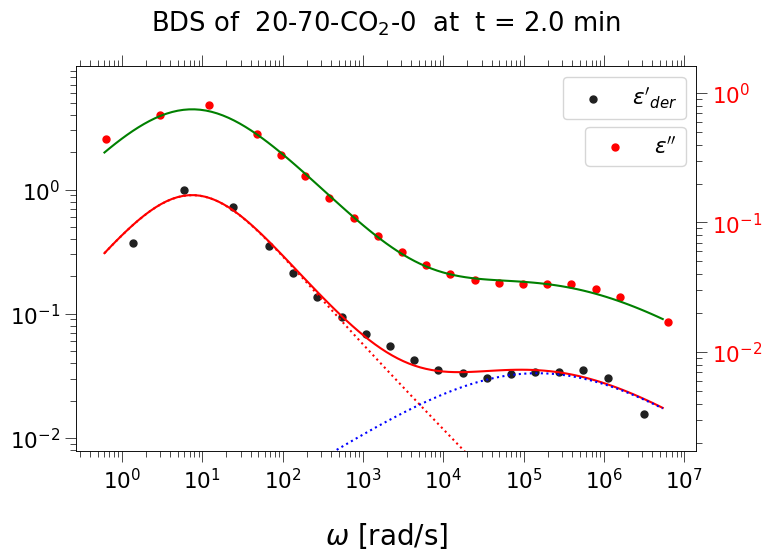

fit score 487356.0
fit parameters [2.593, 0.6659, 6.901, 0.1834, 0.4086, 140600.0, 1e-10, 1.0, 1e-10]


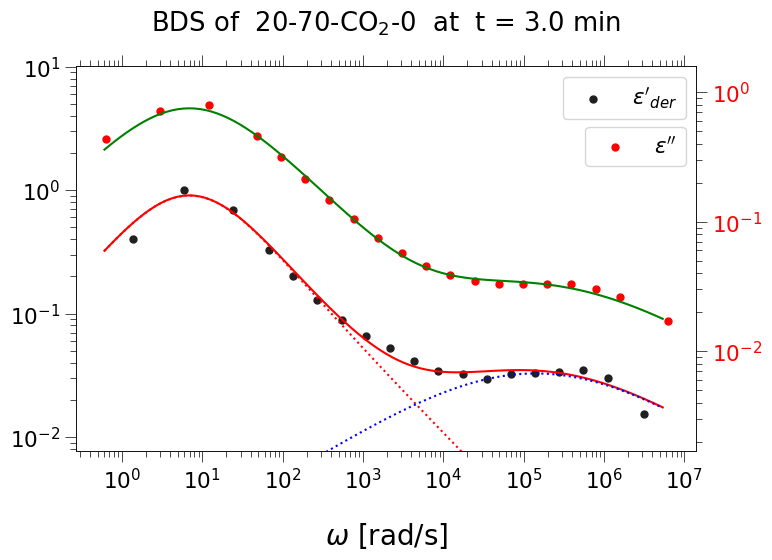

fit score 1331082.0
fit parameters [2.588, 0.67, 5.089, 0.1816, 0.3878, 120100.0, 1e-10, 1.0, 1e-10]


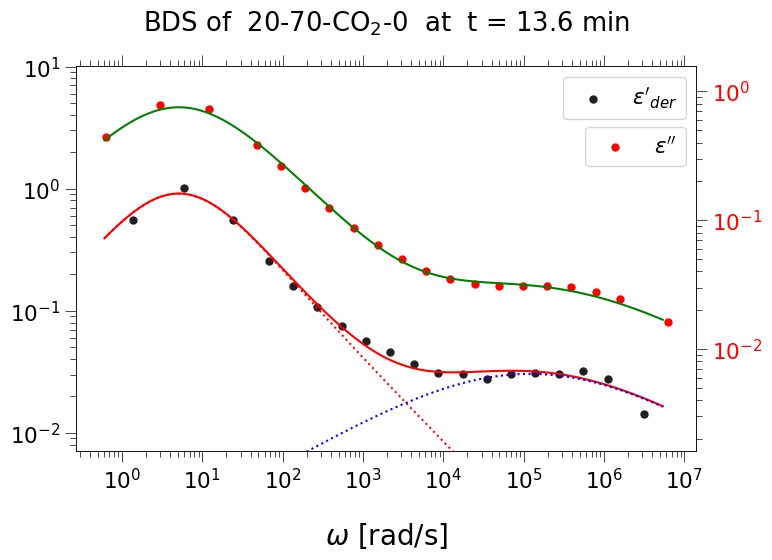

fit score 1708495.0
fit parameters [2.566, 0.6637, 4.379, 0.1728, 0.3872, 120100.0, 1e-10, 1.0, 1e-10]


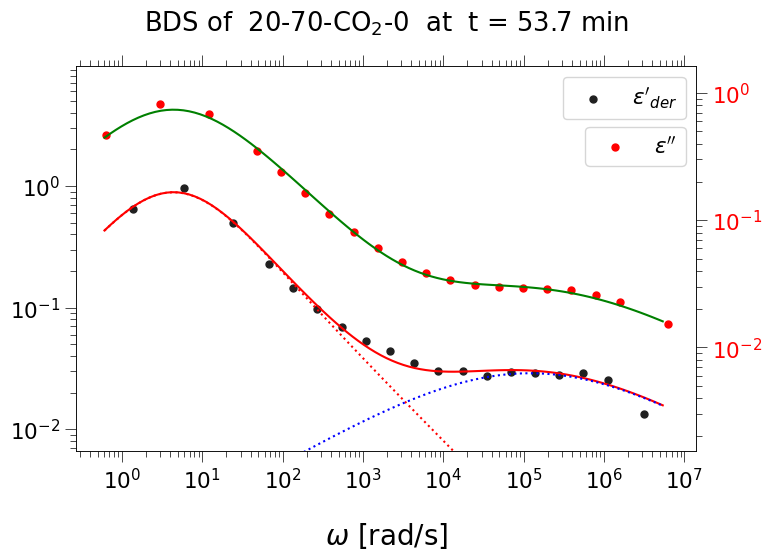

fit score 1547382.0
fit parameters [2.606, 0.6503, 3.705, 0.163, 0.3954, 120100.0, 1e-10, 1.0, 1e-10]


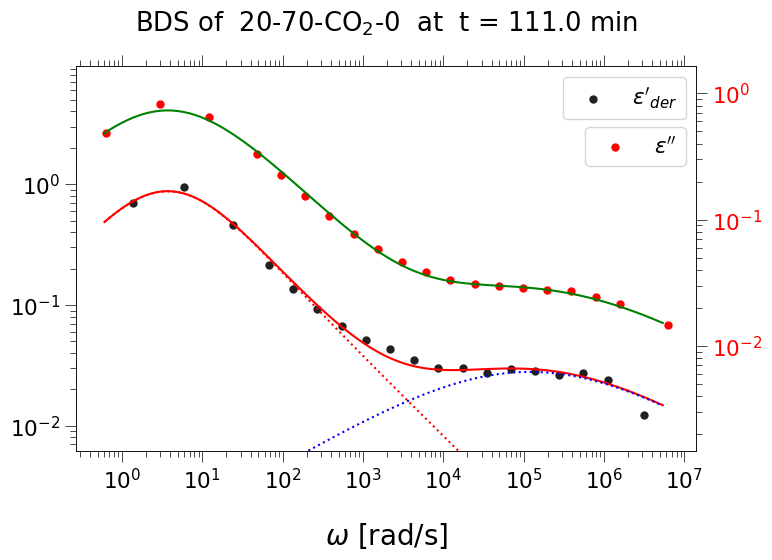

fit score 102763.0
fit parameters [2.347, 0.6233, 11.89, 0.1105, 0.5115, 271000.0, 1949000.0, 0.8305, 3.42e-09]


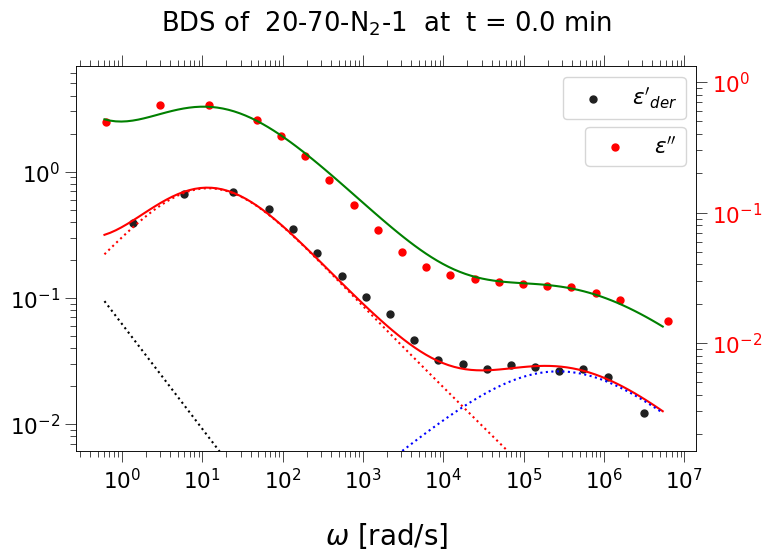

fit score 37821973.0
fit parameters [2.033, 0.772, 216.8, 0.5646, 0.3092, 5648.0, 1775000.0, 0.8423, 9.372e-08]


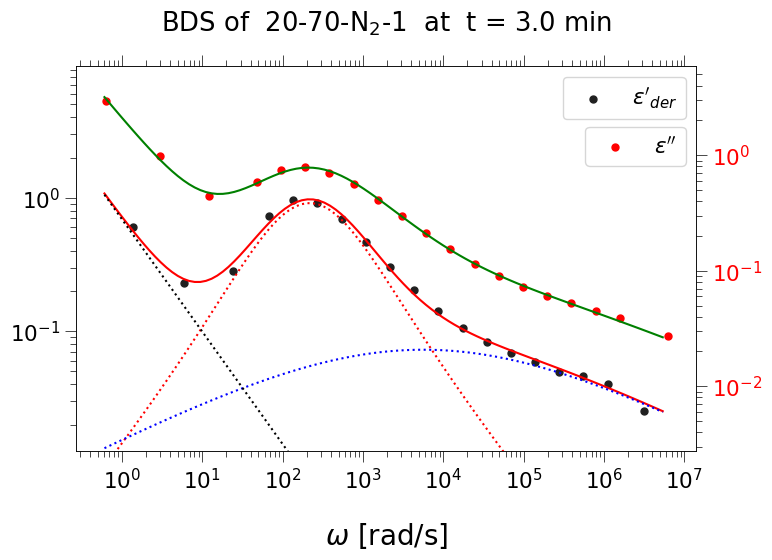

fit score 137463408.0
fit parameters [1.588, 0.7746, 507.2, 1.049, 0.368, 4675.0, 11540000.0, 0.8, 1.86e-08]


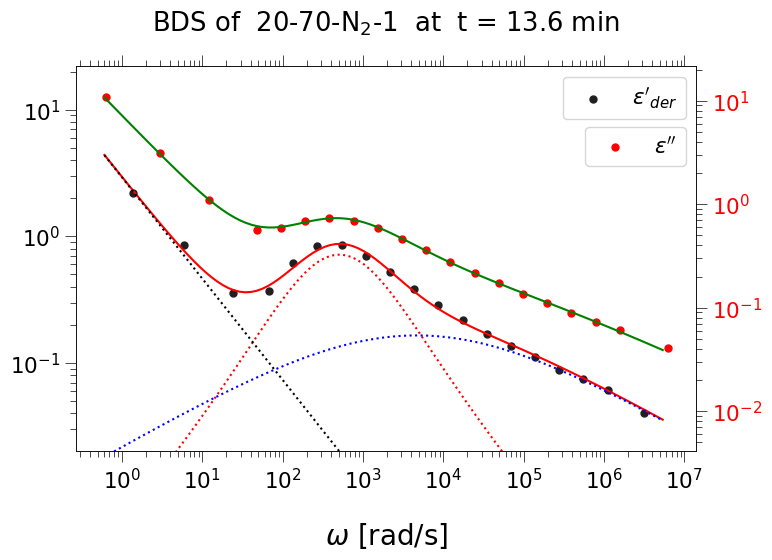

fit score 484208368.0
fit parameters [1.347, 0.7931, 780.8, 1.411, 0.3698, 5365.0, 28660000.0, 0.7757, 6.65e-09]


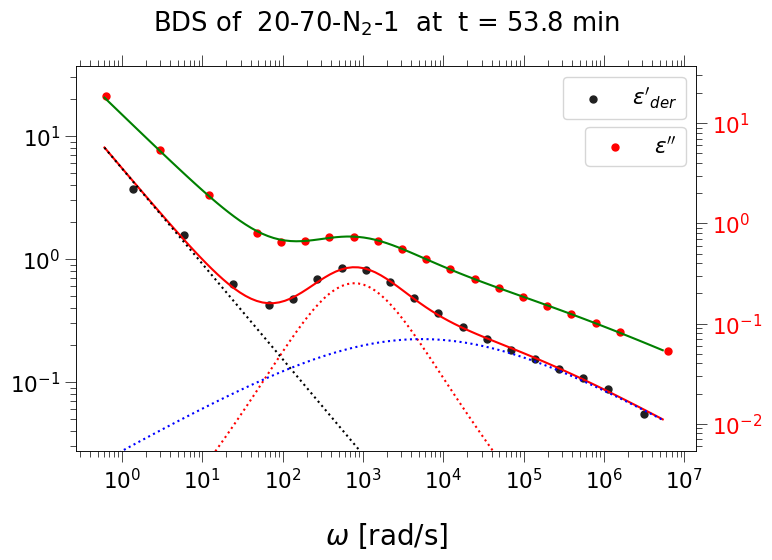

fit score 199289158.0
fit parameters [1.193, 0.8124, 855.4, 1.646, 0.3723, 3774.0, 30980000.0, 0.7612, 4.519e-09]


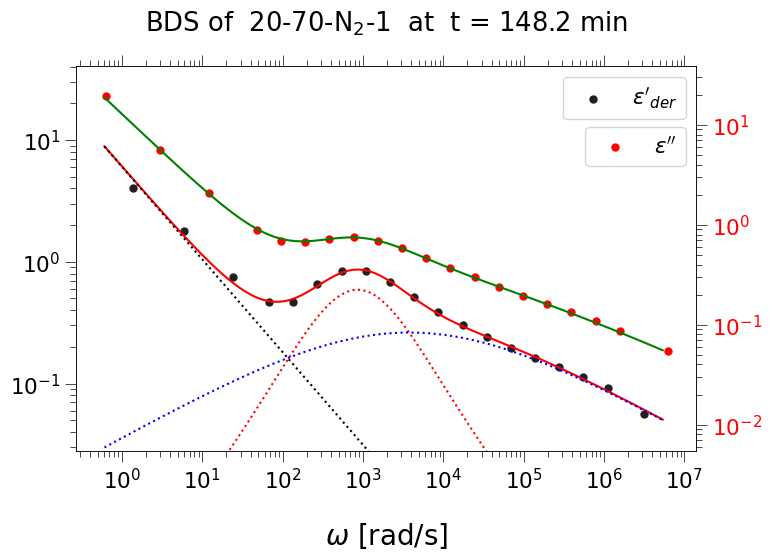

FALLBACK 1:  9.0
FALLBACK 1:  813.0
FALLBACK 2:  45741.0
fit score 45741.0
fit parameters [2.636, 0.6287, 8.604, 0.1556, 0.4854, 240400.0, 1e-10, 1.0, 1e-10]


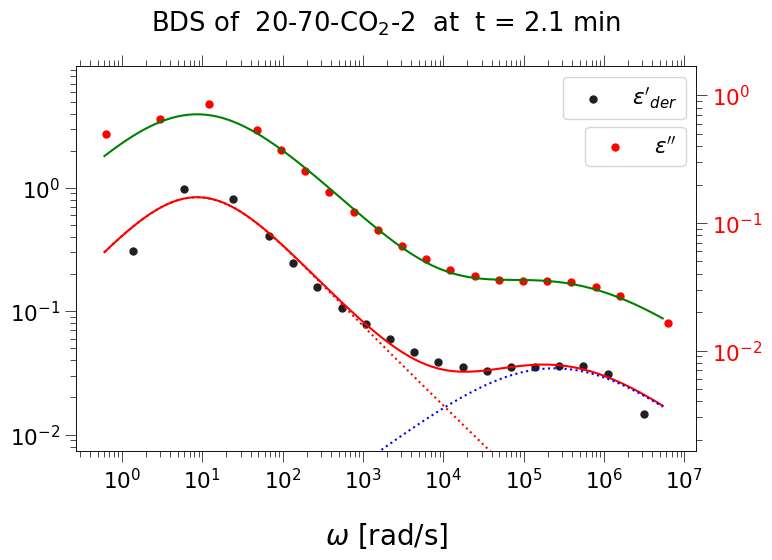

FALLBACK 1:  73002.0
fit score 89343.0
fit parameters [2.664, 0.6384, 7.181, 0.1511, 0.488, 240400.0, 1e-10, 1.0, 1e-10]


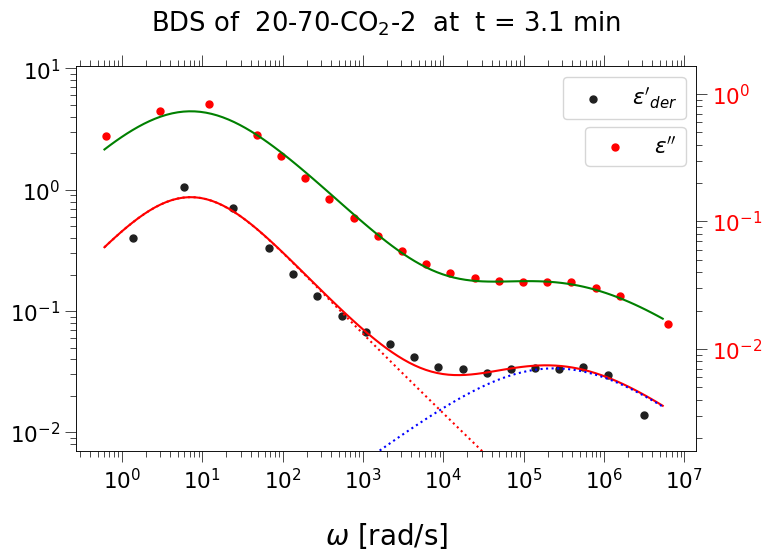

FALLBACK 2:  156968.0
FALLBACK 2:  563699.0
fit score 392988.0
fit parameters [2.609, 0.6709, 4.479, 0.1639, 0.423, 120200.0, 1e-10, 1.0, 1e-10]


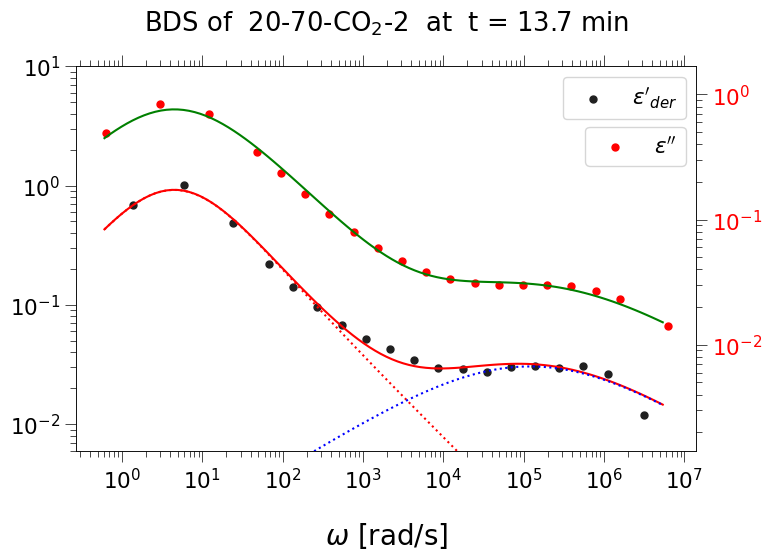

fit score 798703.0
fit parameters [2.676, 0.6471, 3.572, 0.155, 0.4251, 120200.0, 1e-10, 1.0, 1e-10]


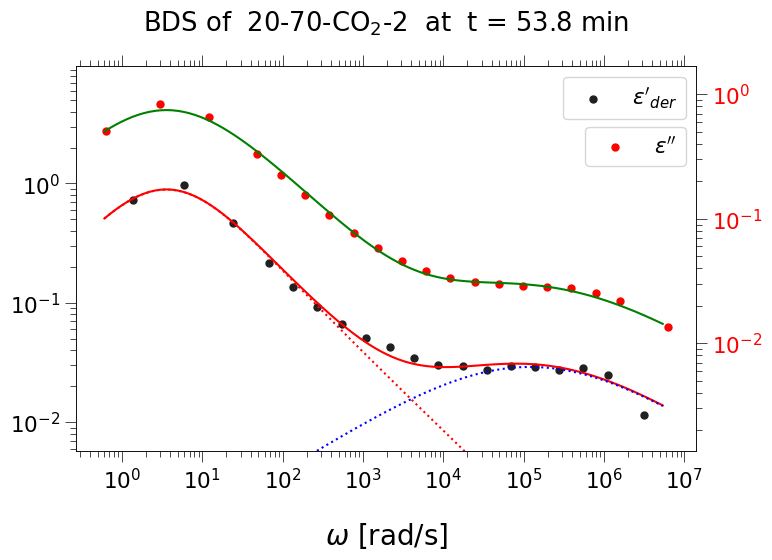

fit score 453385.0
fit parameters [2.759, 0.6269, 2.881, 0.1432, 0.4346, 120200.0, 1e-10, 1.0, 1e-10]


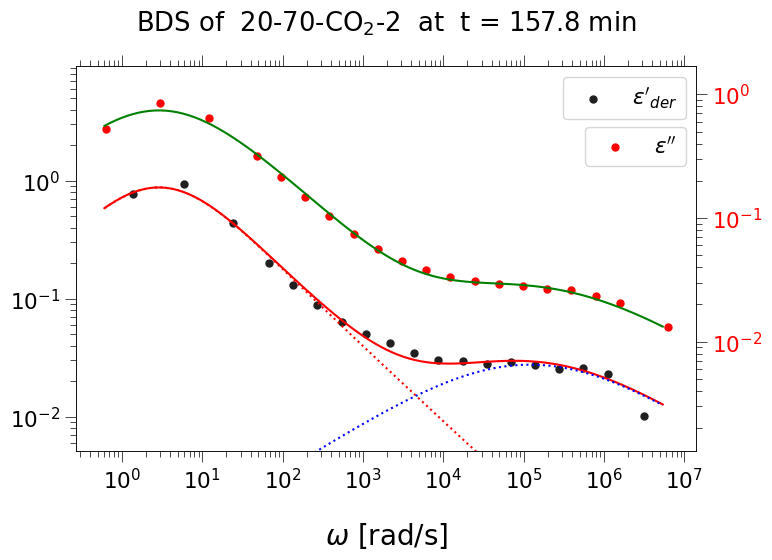

fit score 281113.0
fit parameters [4.216, 0.4159, 1.343, 0.09573, 0.4955, 529600.0, 108100.0, 0.9827, 3.220000000000001e-36]


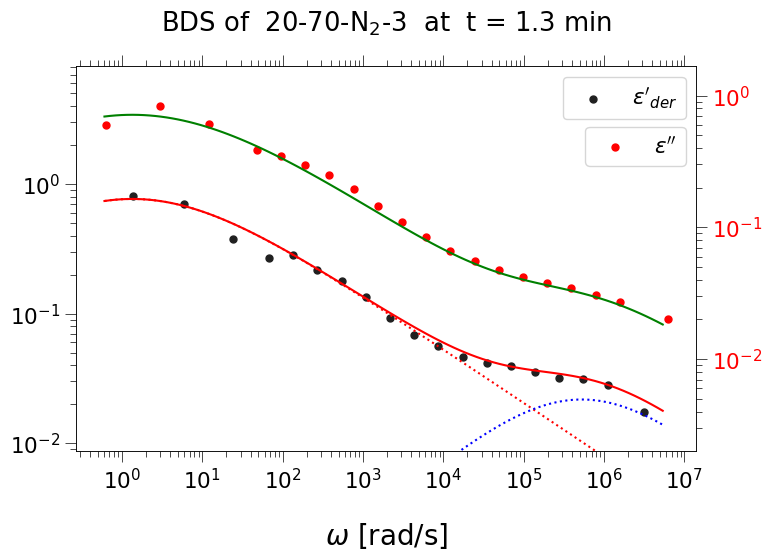

fit score 64036055.0
fit parameters [2.062, 0.7521, 176.3, 0.562, 0.2824, 4593.0, 80130.0, 0.8117, 1.743e-06]


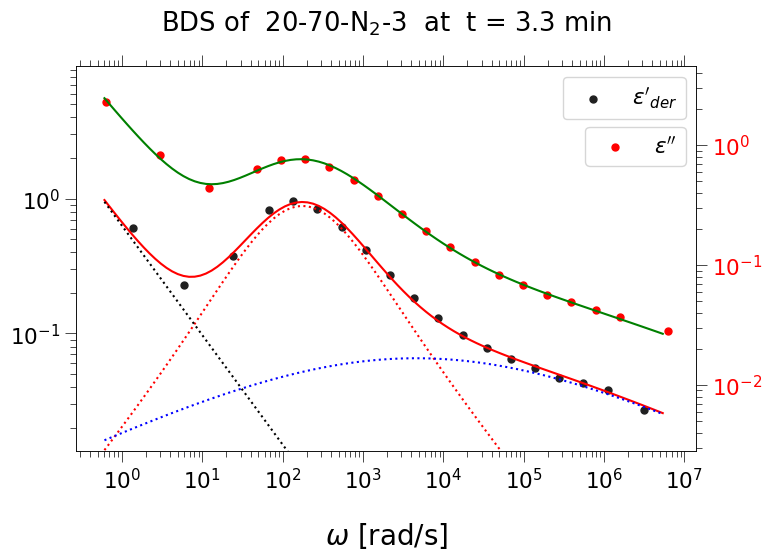

fit score 161753399.0
fit parameters [1.572, 0.7647, 465.3, 1.087, 0.3527, 3487.0, 570300.0, 0.7387, 1.587e-07]


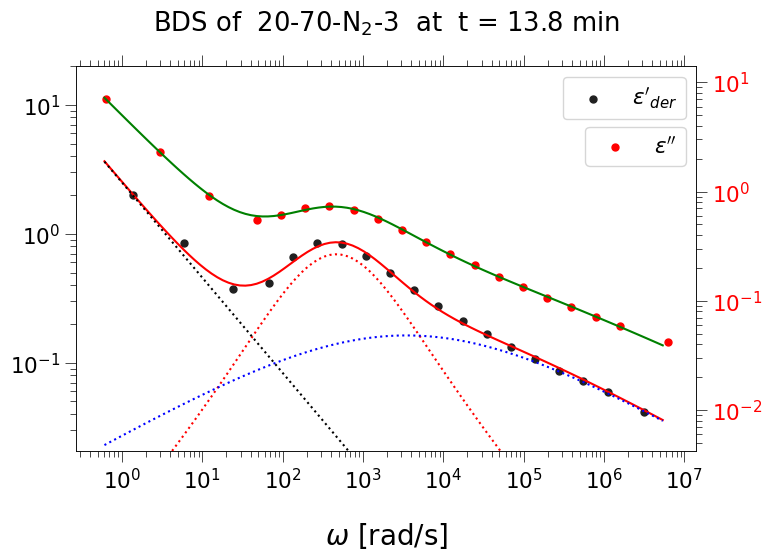

fit score 959075450.0
fit parameters [1.329, 0.7923, 754.5, 1.448, 0.3618, 4702.0, 6680000.0, 0.741, 1.497e-08]


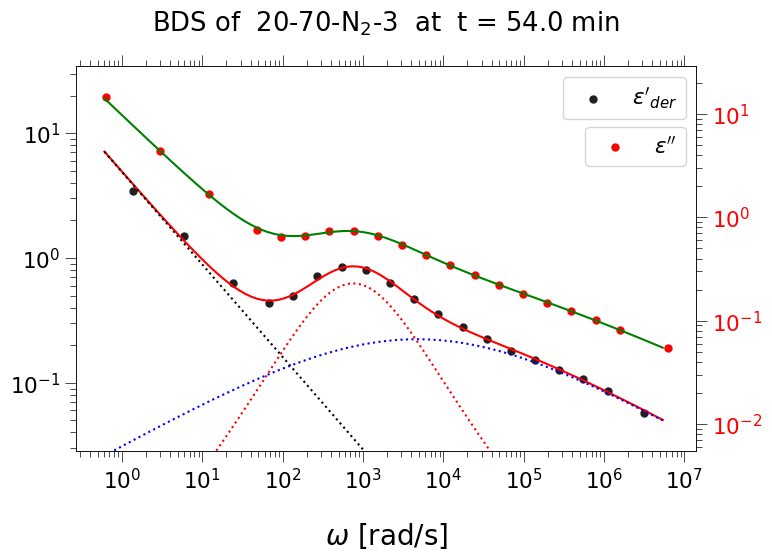

fit score 411706326.0
fit parameters [1.229, 0.8069, 887.1, 1.614, 0.3671, 4122.0, 12000000.0, 0.7453, 9.886e-09]


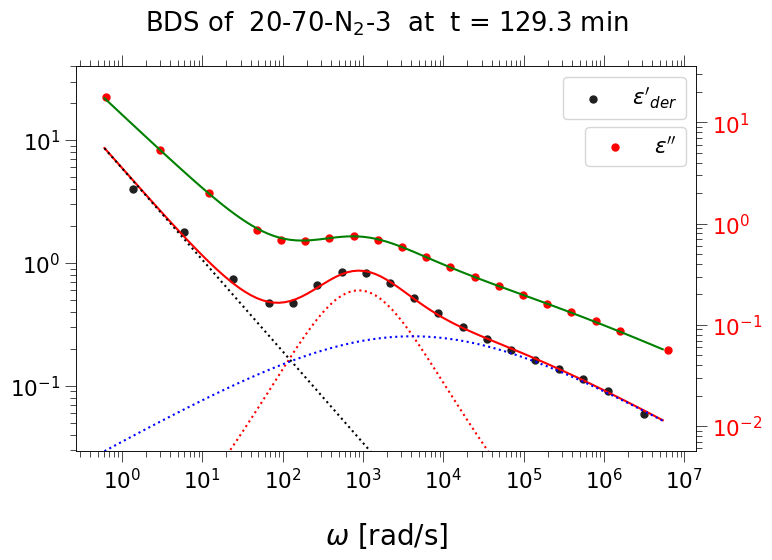

/tmp/ipykernel_113241/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


fit score 5484655.0
fit parameters [1.846, 0.6712, 10.48, 0.2292, 0.3184, 22760.0, 4530000.0, 1.0, 3.785e-08]


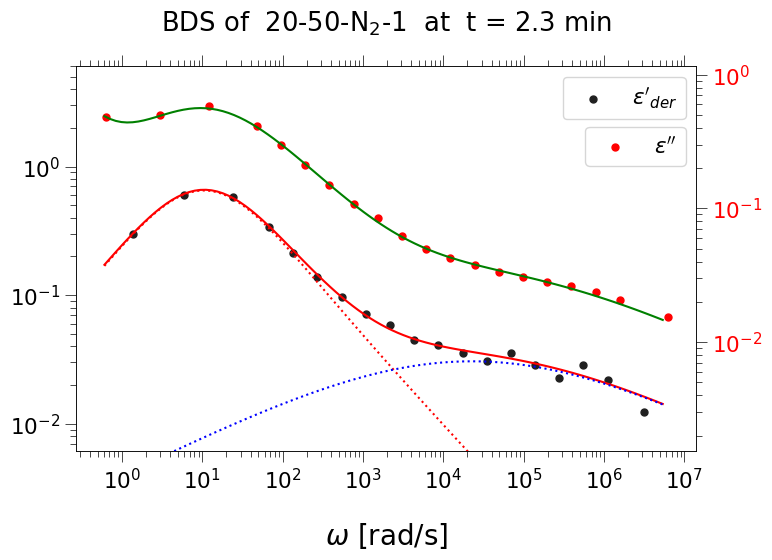

fit score 14920786.0
fit parameters [1.788, 0.7027, 13.46, 0.2776, 0.2882, 10310.0, 2696000.0, 1.0, 7.563e-08]


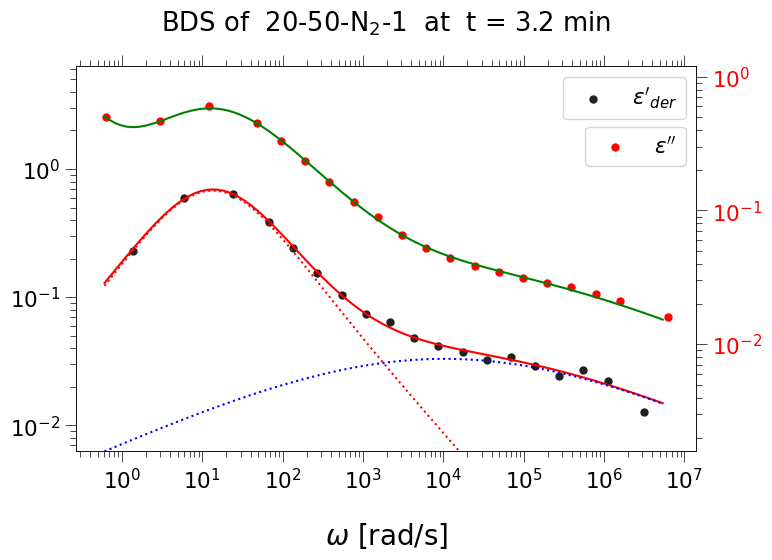

fit score 95977459.0
fit parameters [1.71, 0.7154, 28.12, 0.3561, 0.259, 5130.0, 35270000.0, 0.9768, 6.81e-09]


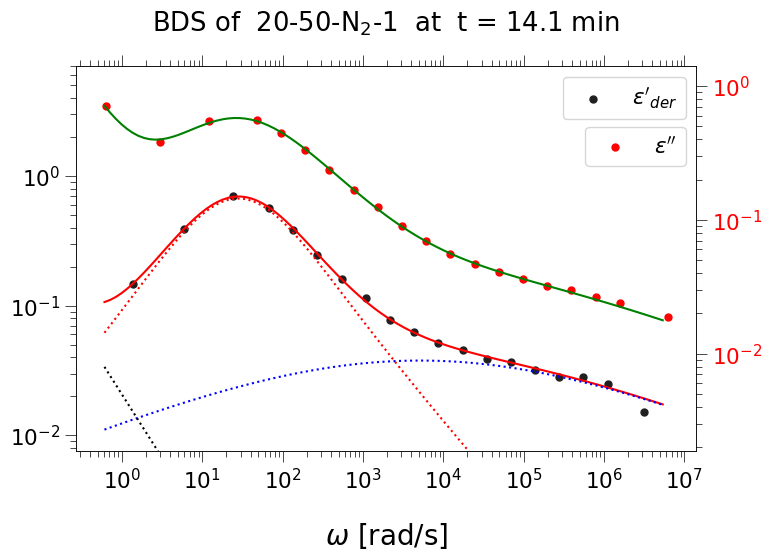

fit score 5888803.0
fit parameters [1.414, 0.7468, 87.25, 0.6153, 0.2692, 1139.0, 74590000.0, 0.8945, 1.518e-09]


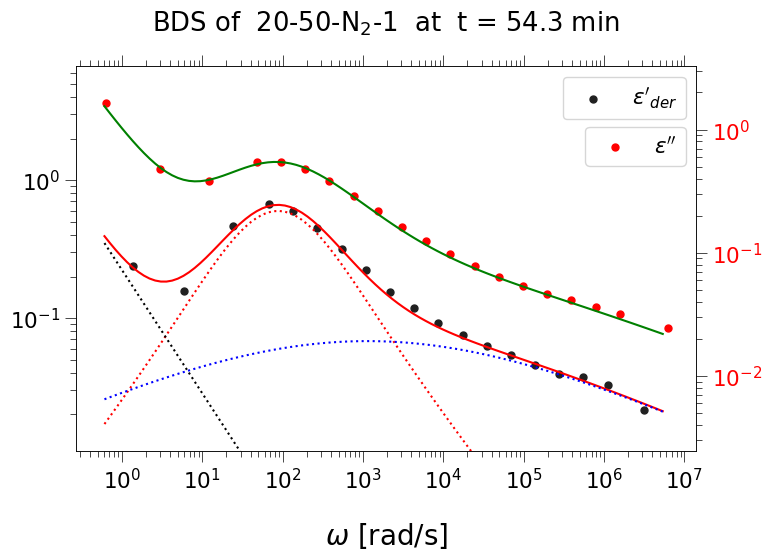

FALLBACK 1:  4290.0
fit score 1544407.0
fit parameters [1.339, 0.7491, 115.7, 0.6875, 0.3033, 1828.0, 60820000.0, 0.8597, 1.372e-09]


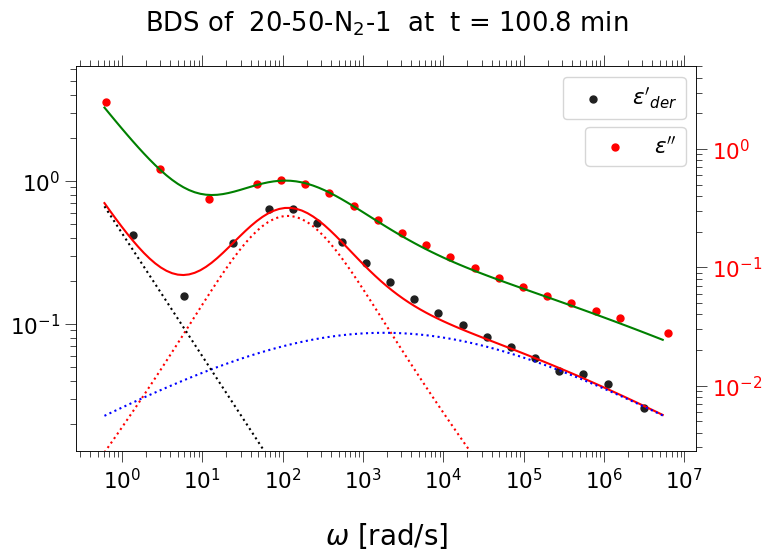

fit score 87043.0
fit parameters [0.4867, 0.7016, 98.34, 0.2157, 0.3363, 14110.0, 8355.0, 0.5927, 6.783e-07]


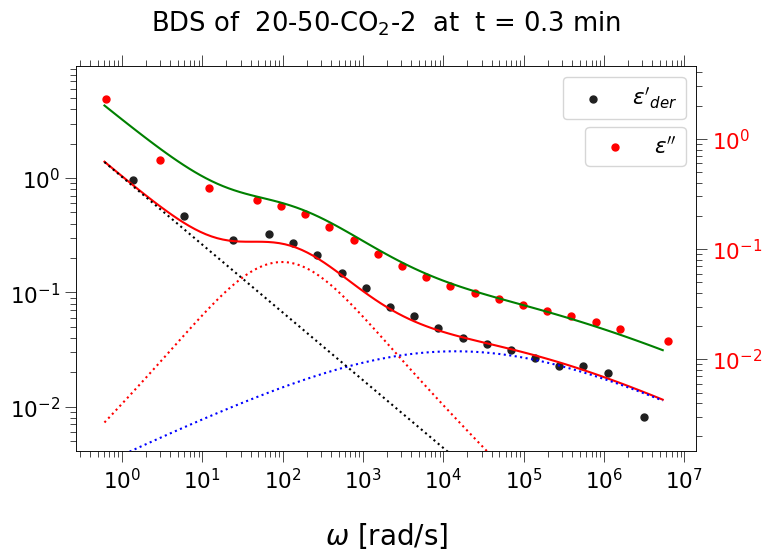

fit score 186203.0
fit parameters [0.02298, 0.7292, 920.7, 0.1083, 0.4447, 71000.0, 7571.0, 0.474, 9.297e-09]


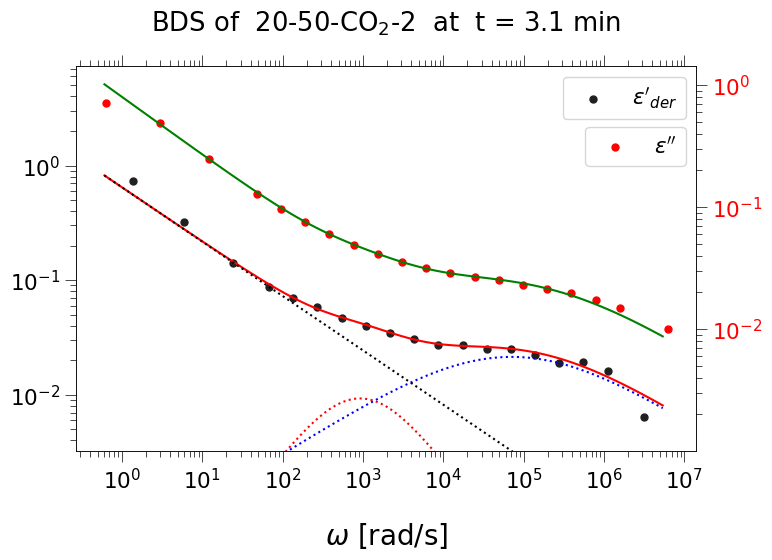

fit score 316725.0
fit parameters [0.1373, 0.3276, 2000.0, 0.02702, 0.6629, 223000.0, 10110.0, 0.5177, 1.325e-08]


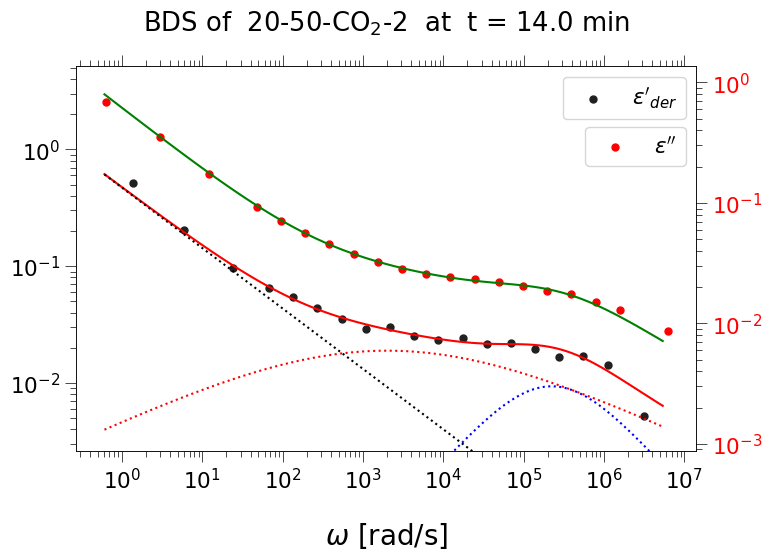

fit score 372551.0
fit parameters [0.1496, 0.3141, 2000.0, 0.02386, 0.709, 263500.0, 17470.0, 0.5393, 9.529e-09]


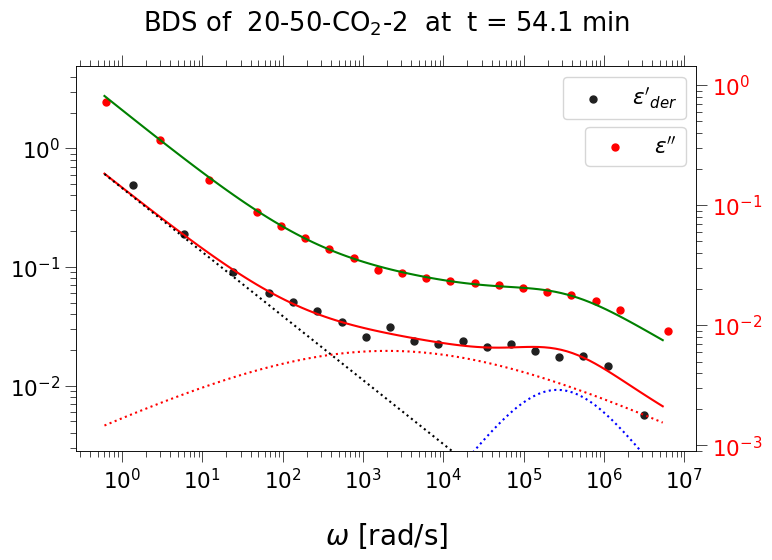

fit score 904158.0
fit parameters [0.1579, 0.3032, 1972.0, 0.0218, 0.7351, 292600.0, 25660.0, 0.5508, 7.056e-09]


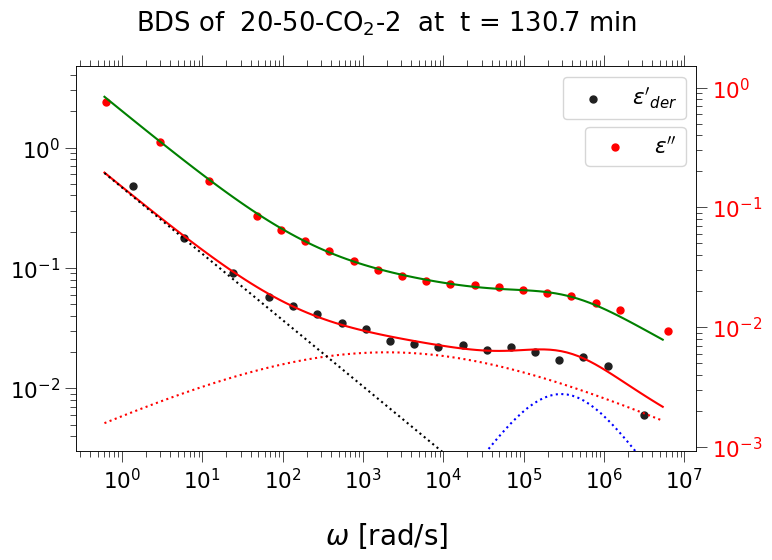

fit score 22756.0
fit parameters [0.9102, 0.7745, 12.09, 0.2461, 0.3178, 3630.0, 36040000.0, 1.0, 1.257e-08]


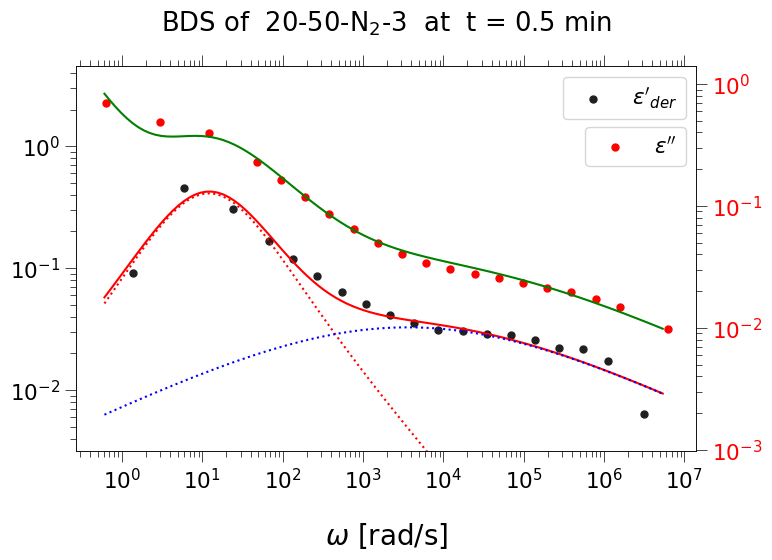

fit score 74751539.0
fit parameters [1.69, 0.7119, 13.37, 0.3005, 0.2687, 5920.0, 6437000.0, 1.0, 3.351e-08]


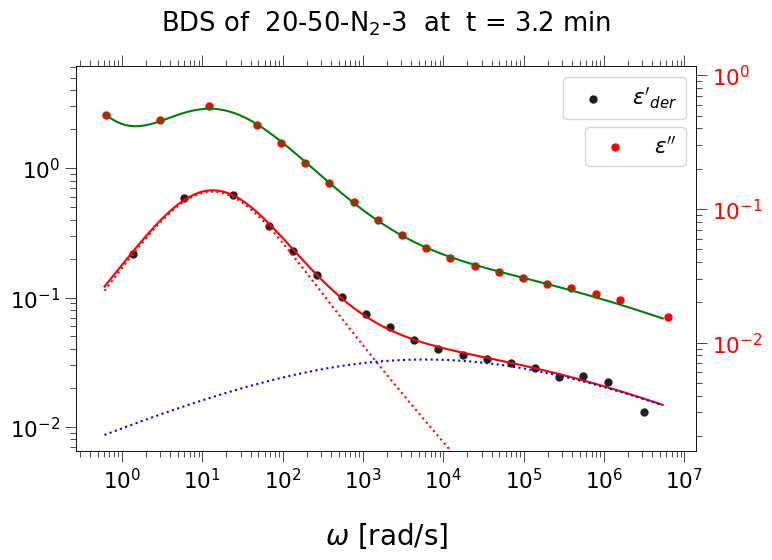

fit score 175313176.0
fit parameters [1.625, 0.7357, 25.6, 0.4101, 0.2381, 1598.0, 6513000.0, 1.0, 4.317e-08]


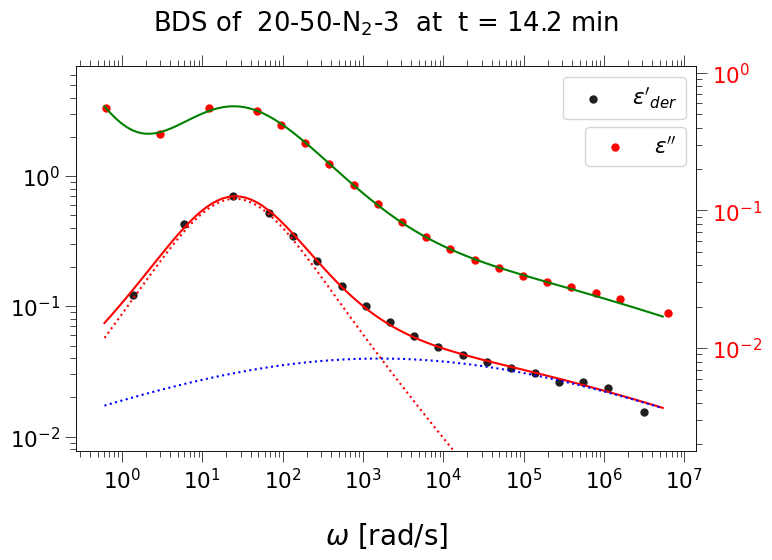

fit score 13214728.0
fit parameters [1.444, 0.7422, 78.91, 0.5657, 0.2693, 1351.0, 43710000.0, 0.8878, 1.956e-09]


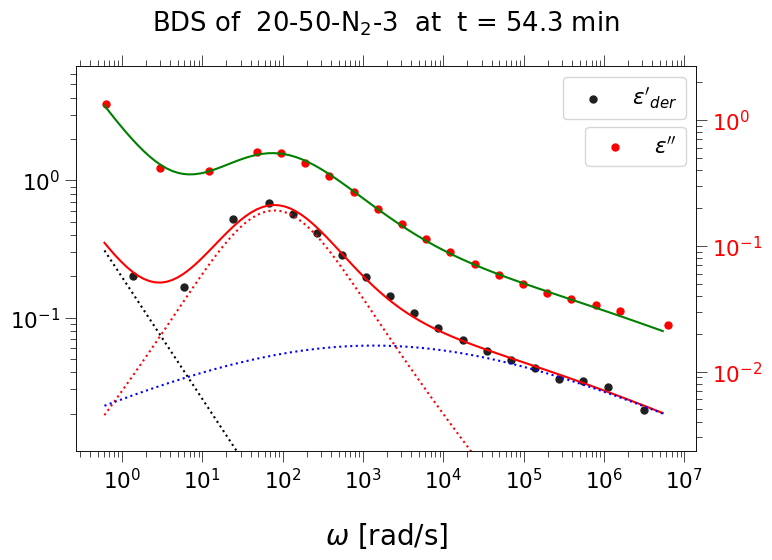

/tmp/ipykernel_113241/1474685501.py:29: RuntimeWarning: invalid value encountered in log
  ln_er_der = np.log(er_der)


FALLBACK 1:  3946645666.0
fit score 3946645666.0
fit parameters [1.883, 0.5876, 17.13, 0.4329, 0.3656, 17470.0, 18.48, 0.9999, 0.05574]


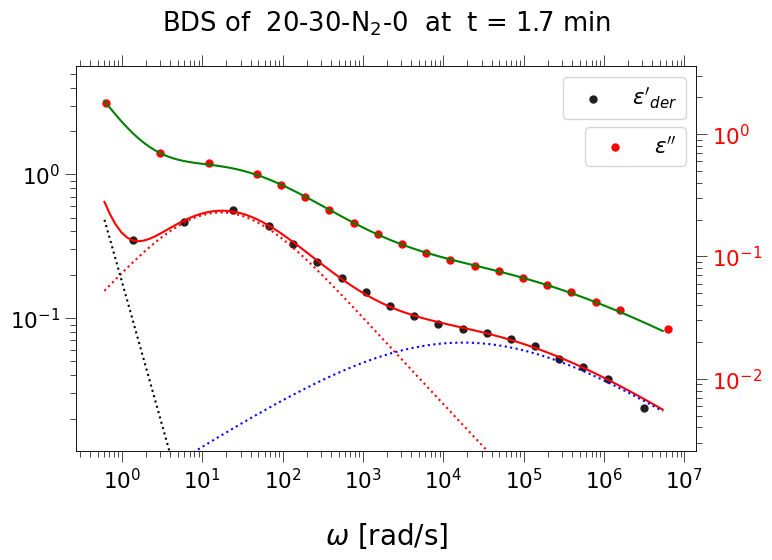

fit score 5016041064.0
fit parameters [1.89, 0.5841, 18.64, 0.4235, 0.3701, 21110.0, 15.77, 1.0, 0.07339]


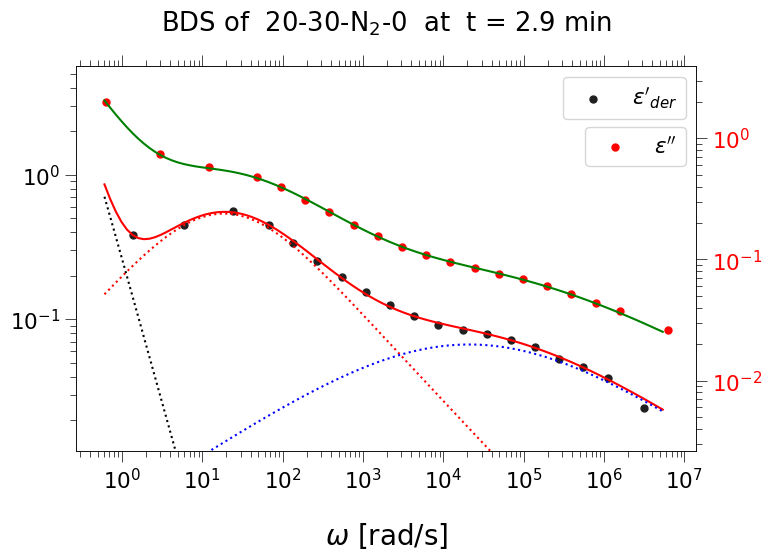

fit score 2897903874.0
fit parameters [1.9, 0.6058, 36.85, 0.4261, 0.3912, 41110.0, 13.6, 1.0, 0.1867]


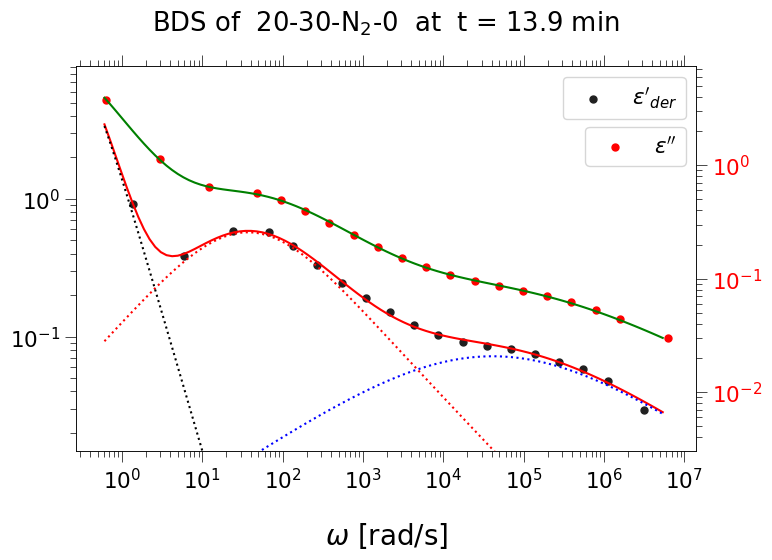

fit score 978872320.0
fit parameters [1.868, 0.6186, 68.31, 0.4041, 0.4107, 85790.0, 64.42, 0.9234, 0.06588]


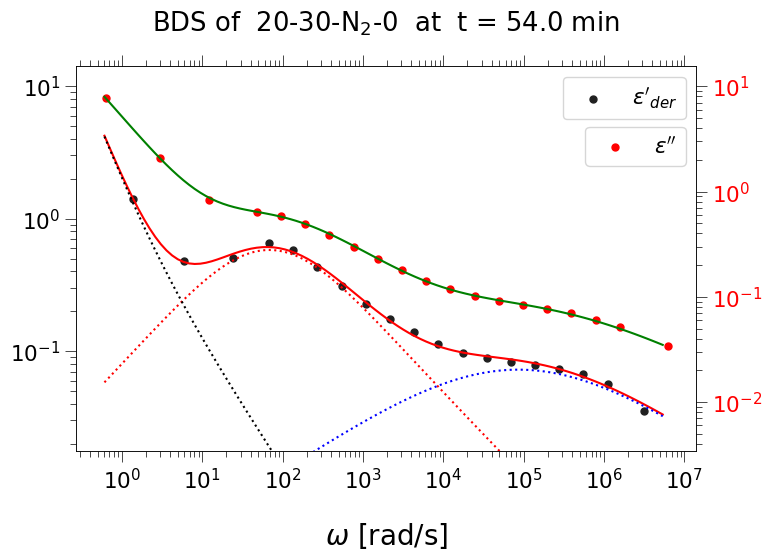

fit score 803673427.0
fit parameters [1.868, 0.6182, 68.61, 0.403, 0.4106, 87070.0, 65.11, 0.9219, 0.06513]


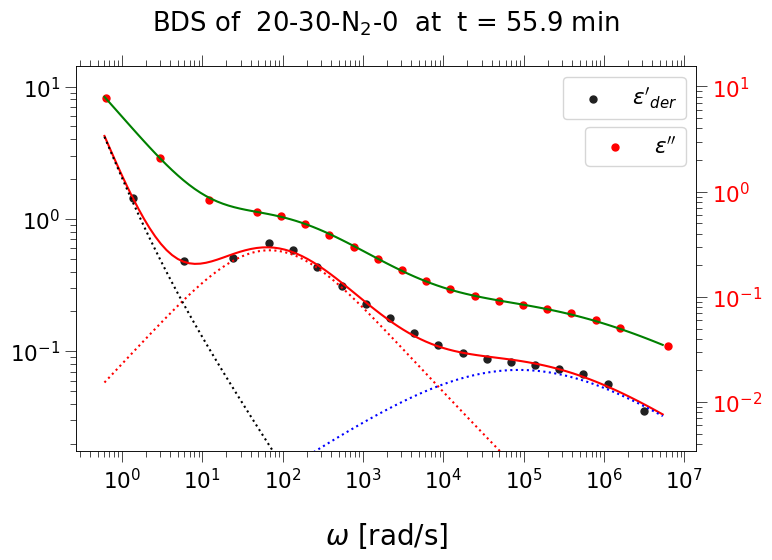

fit score 1034301.0
fit parameters [0.08068, 0.8297, 1643.0, 0.1182, 0.5727, 166200.0, 7668.0, 0.5295, 5.31e-08]


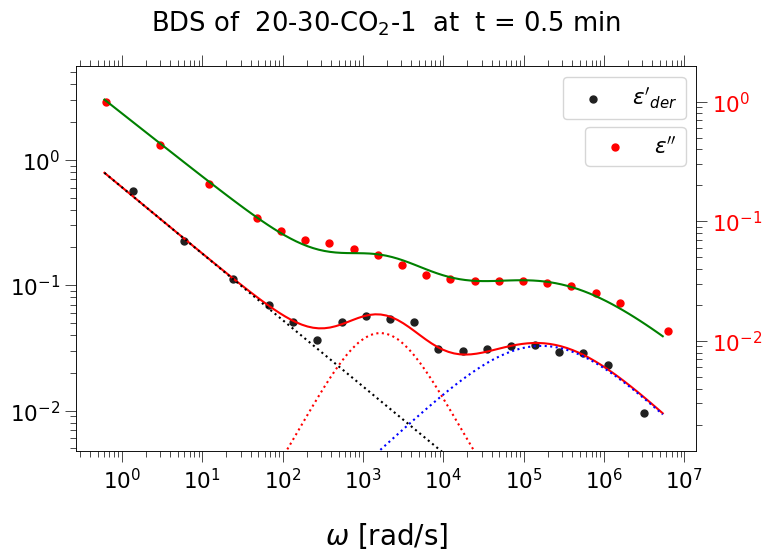

FALLBACK 2:  7695614.0
fit score 5023954.0
fit parameters [0.2887, 0.3128, 252.6, 0.04568, 0.7414, 282000.0, 7.585, 0.6803, 0.03819]


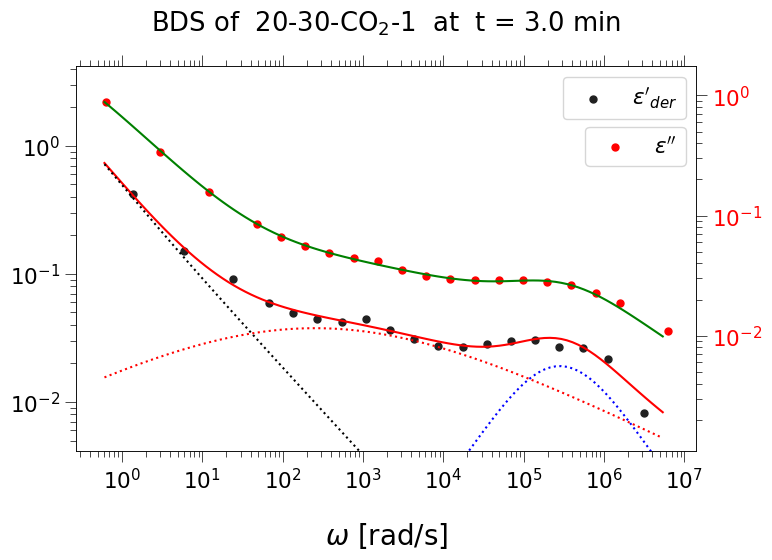

fit score 3721176.0
fit parameters [0.2501, 0.3057, 326.2, 0.03815, 0.7538, 298200.0, 132.0, 0.6647, 0.0003483]


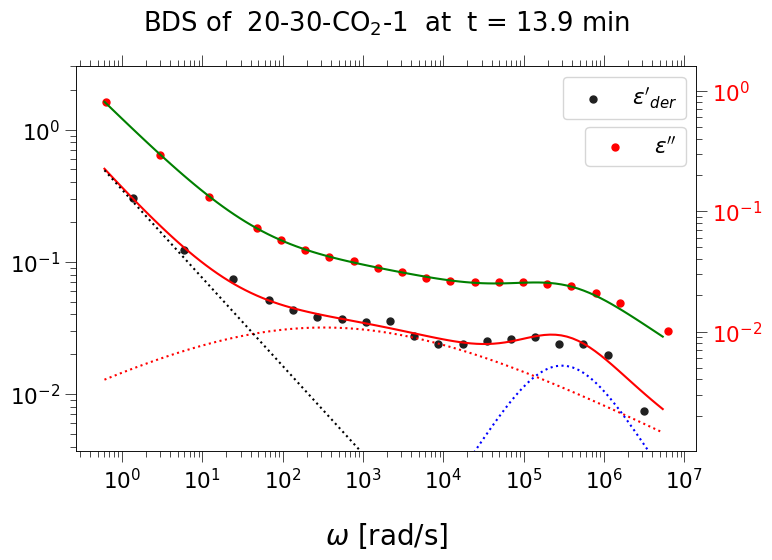

fit score 3517720.0
fit parameters [0.2583, 0.2852, 348.9, 0.026, 0.8202, 369400.0, 6161.0, 0.7133, 2.951e-06]


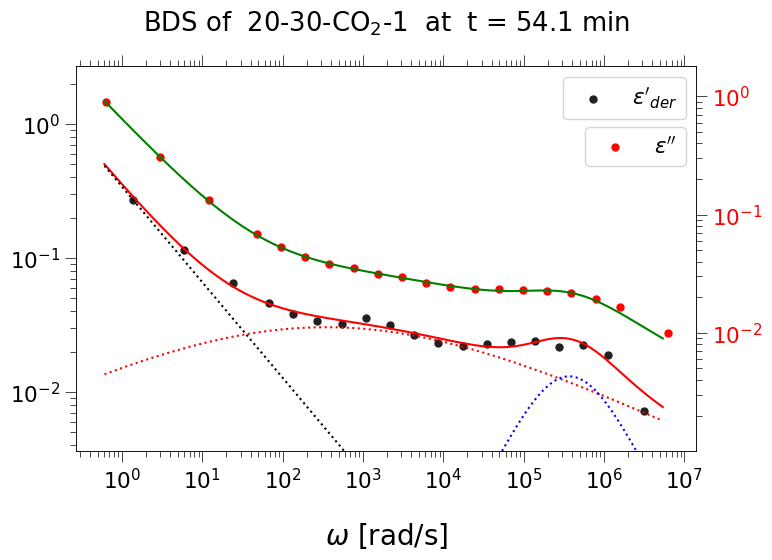

fit score 1800980.0
fit parameters [0.2814, 0.2697, 224.5, 0.02024, 0.8733, 420100.0, 9889.0, 0.7698, 4.652e-06]


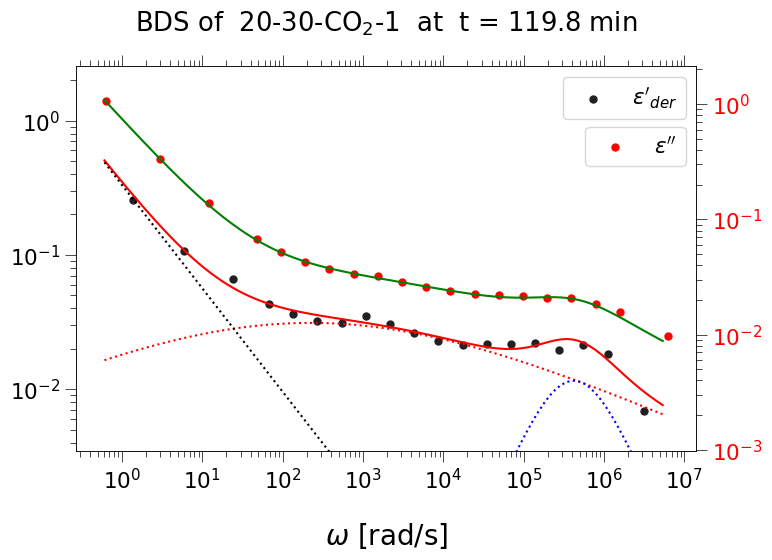

fit score 136548.0
fit parameters [0.5298, 0.71, 5.722, 0.2762, 0.2693, 3555.0, 50960.0, 1.0, 1.326e-05]


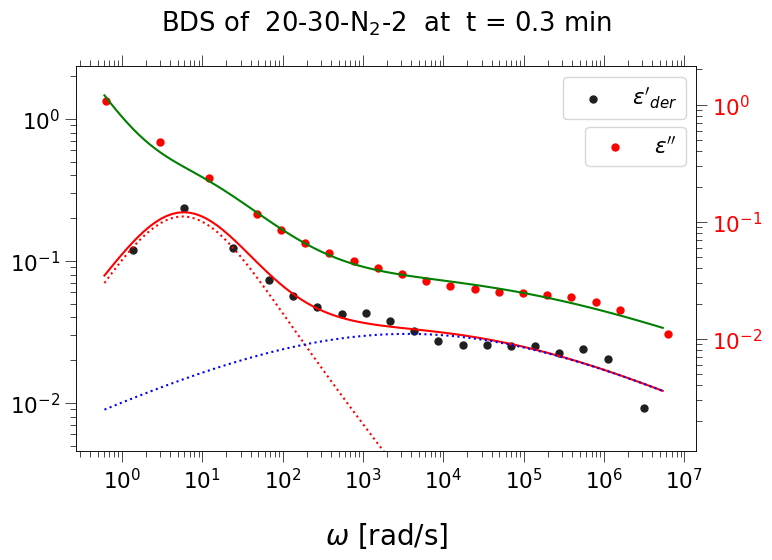

fit score 1094731.0
fit parameters [1.988, 0.6238, 1.716, 0.2662, 0.2806, 10030.0, 15520.0, 1.0, 2.558e-05]


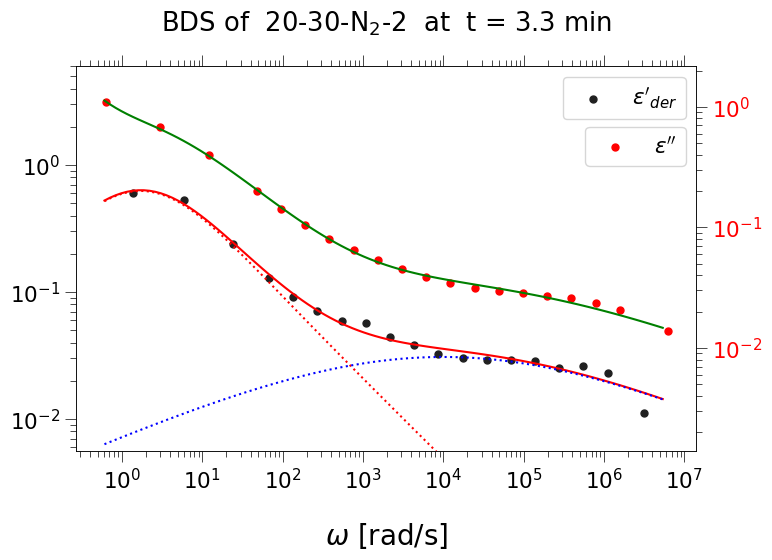

fit score 2290477.0
fit parameters [1.953, 0.6397, 3.072, 0.2501, 0.297, 17370.0, 13250.0, 1.0, 2.292e-05]


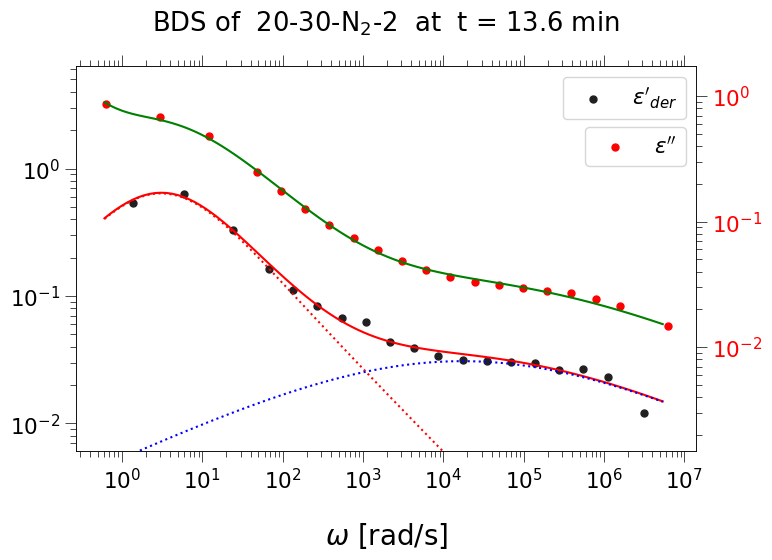

fit score 10224096.0
fit parameters [1.792, 0.6673, 7.244, 0.3118, 0.2631, 12090.0, 19740.0, 1.0, 1.921e-05]


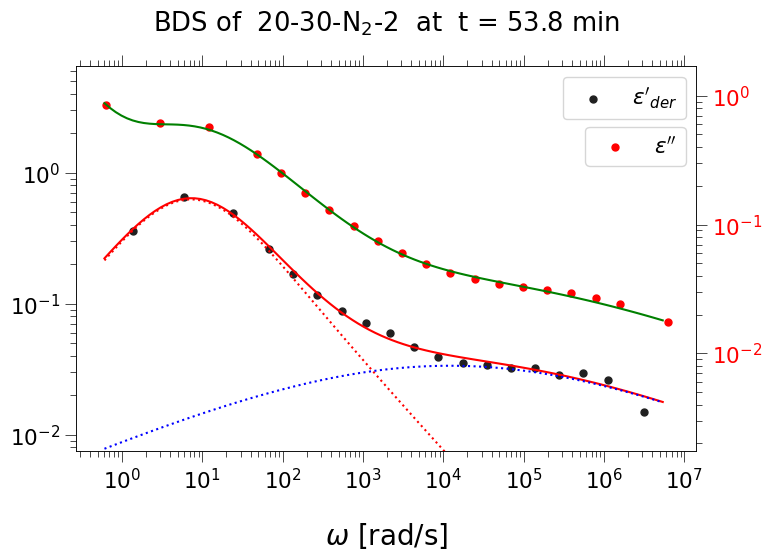

fit score 17604790.0
fit parameters [1.725, 0.6915, 13.36, 0.3757, 0.2449, 7556.0, 76460.0, 1.0, 7.497e-06]


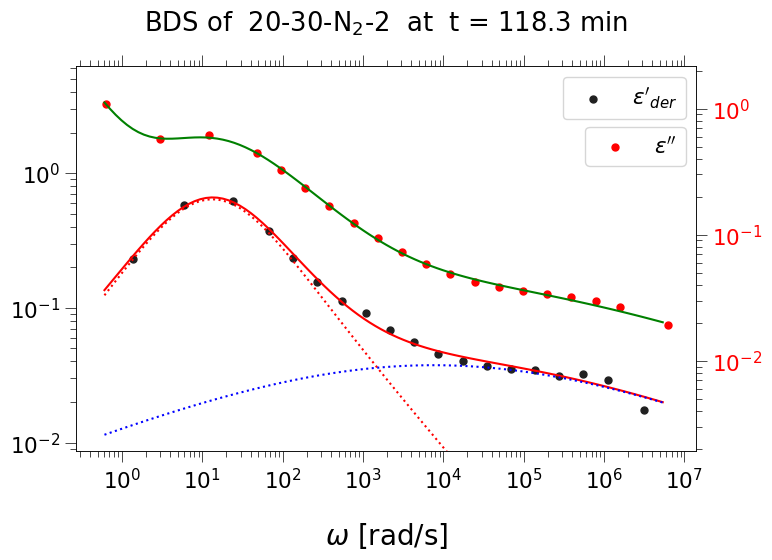

FALLBACK 1:  2733302.0
fit score 2733302.0
fit parameters [0.361, 0.2727, 73.14, 0.02357, 0.8176, 375100.0, 3.341, 0.796, 0.3]


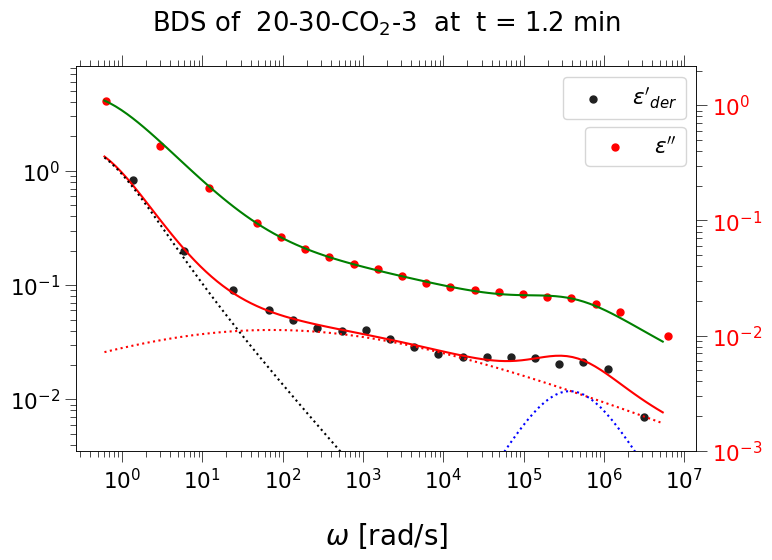

fit score 2277845.0
fit parameters [0.247, 0.3013, 488.4, 0.02123, 0.8545, 410300.0, 12.19, 0.686, 0.024]


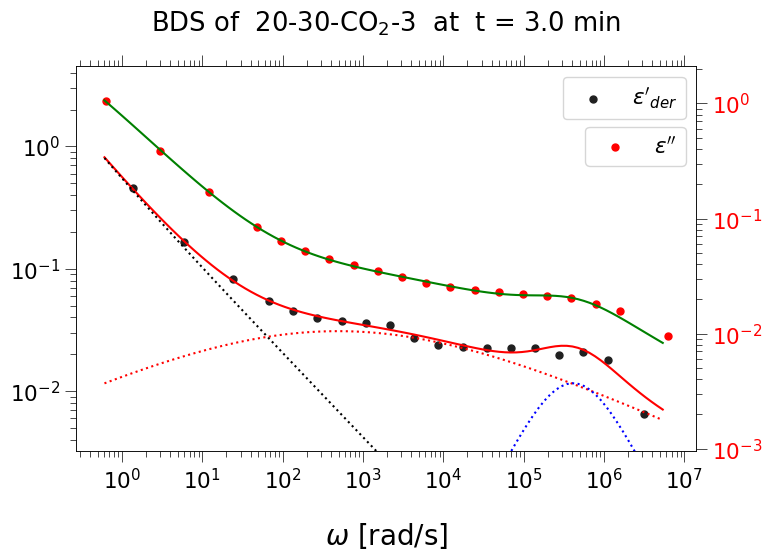

fit score 2040704.0
fit parameters [0.2449, 0.2968, 440.2, 0.02041, 0.868, 420500.0, 259.4, 0.6991, 0.000251]


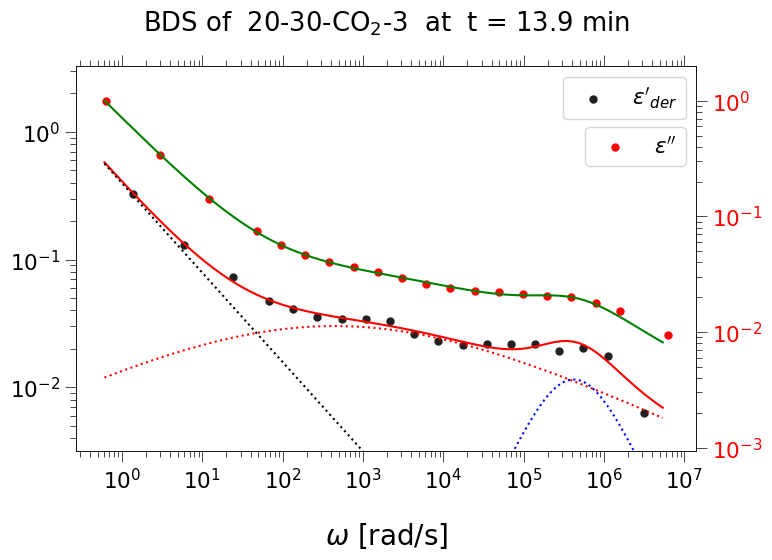

fit score 1065078.0
fit parameters [0.2752, 0.2777, 246.4, 0.01907, 0.8898, 448800.0, 10710.0, 0.7606, 4.069e-06]


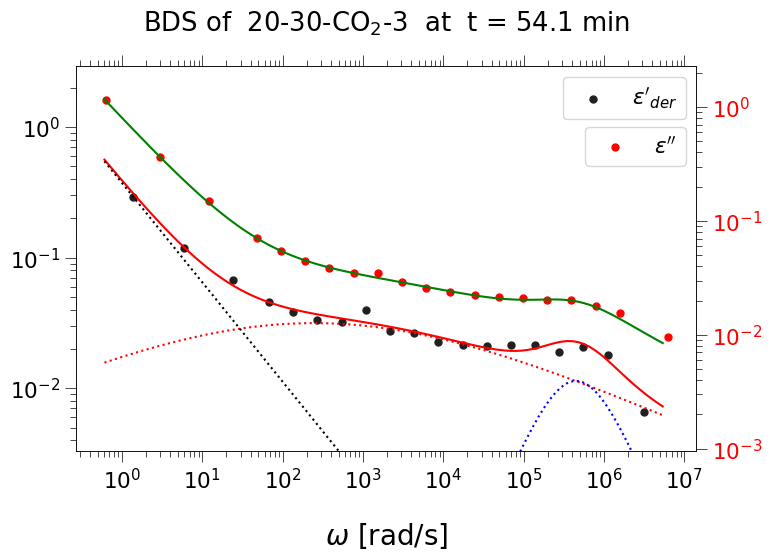

fit score 2749257.0
fit parameters [0.2925, 0.2634, 177.3, 0.01753, 0.9021, 459000.0, 15220.0, 0.7882, 4.144e-06]


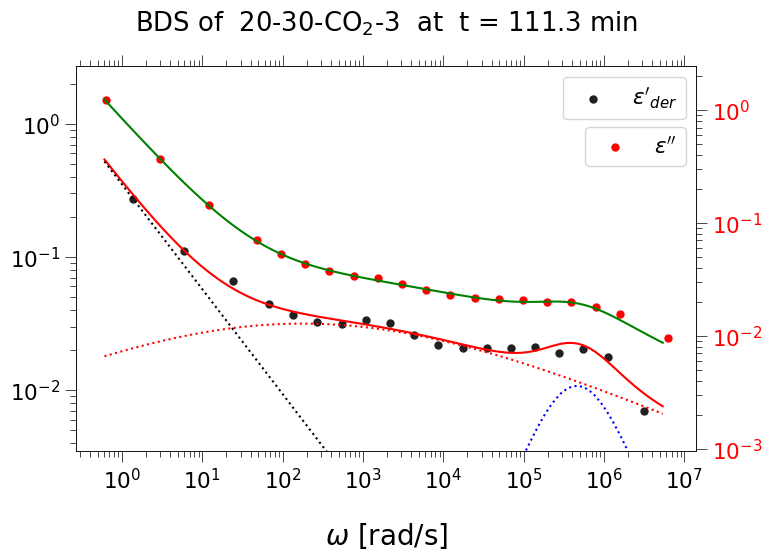

fit score 409656.0
fit parameters [1.65, 0.5276, 1.398, 0.1851, 0.3361, 35740.0, 35250.0, 1.0, 1.795e-05]


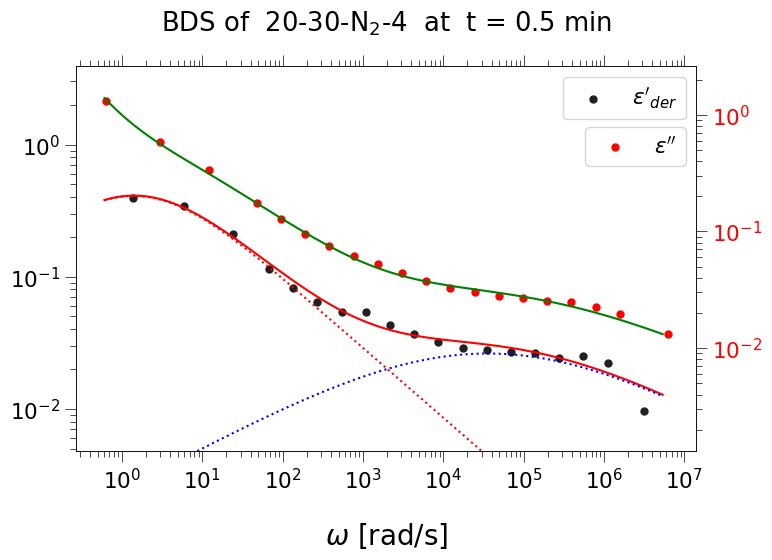

fit score 1318155.0
fit parameters [1.92, 0.6028, 3.338, 0.2426, 0.2983, 21080.0, 31280.0, 0.9997, 1.872e-05]


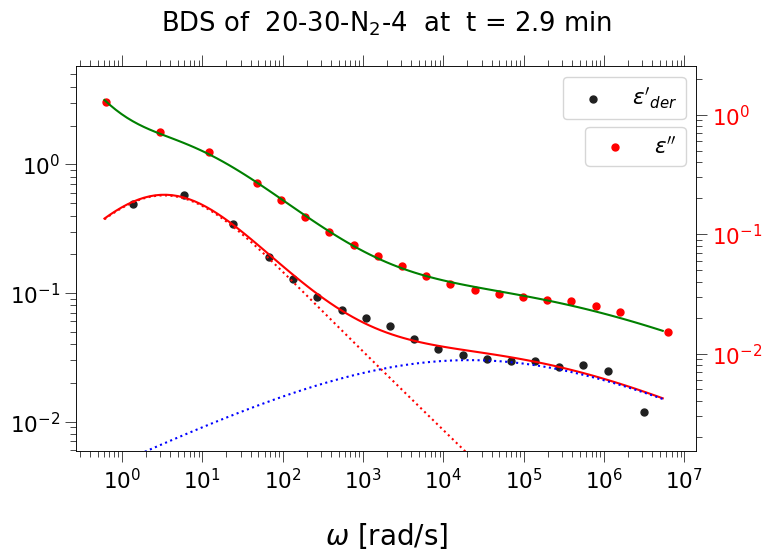

fit score 3548108.0
fit parameters [1.878, 0.6379, 7.498, 0.2726, 0.289, 23120.0, 51540.0, 1.0, 1.282e-05]


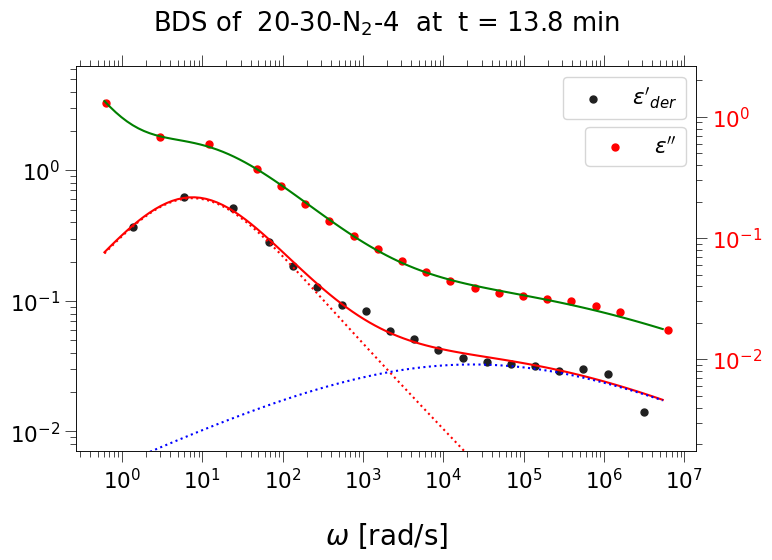

fit score 6459557.0
fit parameters [1.804, 0.6623, 11.28, 0.3047, 0.2751, 18270.0, 229800.0, 1.0, 2.858e-06]


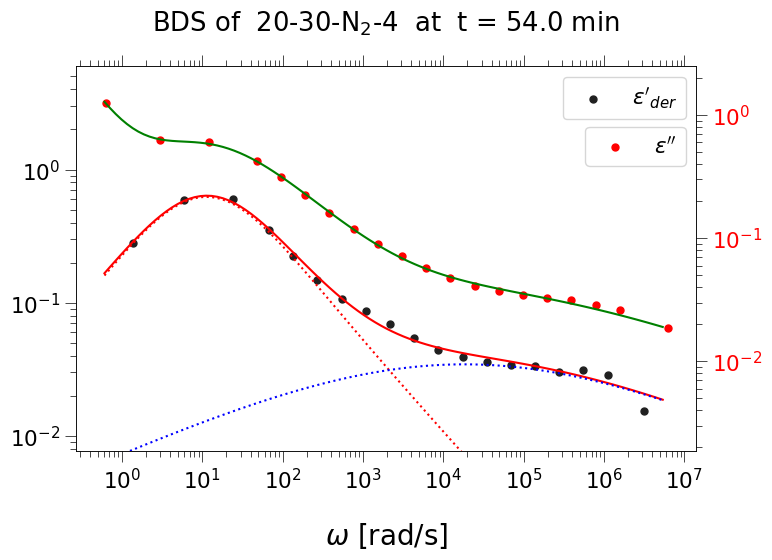

fit score 10816149.0
fit parameters [1.778, 0.6761, 14.39, 0.342, 0.2602, 12650.0, 22150000.0, 1.0, 3.424e-08]


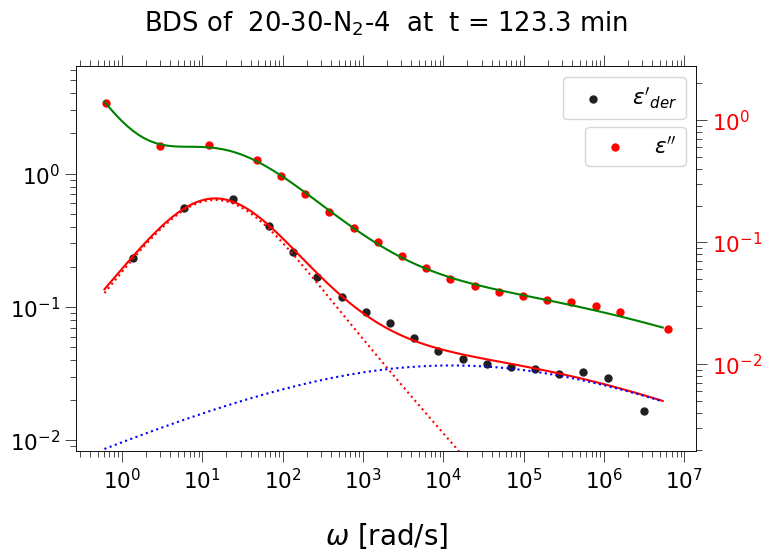

In [6]:
### main

# selection of a few indices where the plot is shown; quadratic: show many at the start and less later
plotI = np.linspace(0,4,4)
plottimes = np.exp( plotI )-1
plottimes = np.append(plottimes, [1e5, 1e5])
# ignore last tol minutes of each run to avoid faulty data from next run
tol = 5

# combined lists that save the fit data, will contain numpy arrays of different length, one array per run
P_ALL = []
DT_ALL = []
A_ALL = []
# save ID for easier handling, P_ALL[j] will correspond to ID[j]
# ID is temperature-gas-run ie. "70-N_2-1", as shown in plots
ID = []

# go throgh all temperatures, or rather their respective datasets
for m, data in enumerate(DATA) :
    temp = str(TEMPS[m])

    # f is an array of the unique frequencies
    # er_der is a 2D array of all "numerical derivative of real part"-values
    # er_der[i] / ei[i] (one row of the matrix) is one spectrum
    # where i corresponds to the time
    # ei[:,k] (one column) is the time evolution at a fixed frequency
    # The array contains one whole measurement with fixed temperature and all gas runs
    f, er_der, ei, t = extract_interpolate_and_derivative(data)
    ln_er_der = np.log(er_der)
    w = 2*np.pi*f
    lnw = np.log(w)
    lnw_der = (lnw[:-1] + lnw[1:]) / 2
    w_der = np.exp(lnw_der)
    
    # go throgh all runs, one run starts with change of gas
    for j, t0 in enumerate(GASCHANGE[m][:-1]) :
        if temp+'-'+str(j) in id_out :
            continue
        gas = GASES[S[m][j]]
        ID.append(temp+'-'+gas+'-'+str(j))
        run_num = len(ID) - 1

        t1 = GASCHANGE[m][j+1]-tol
        # indices of start/end of current run
        t0_i = np.searchsorted(t, t0, side="left")
        t1_i = np.searchsorted(t, t1, side="right")

        p0 = p0_start[run_num]
        # stack of numpy arrays of all fit parameters of current run: [ [a,b,c,...], [a,b,c,...], ... ]
        PARAMS = []
        # stack of times; needed because fit doesn't always converge. DT[i] corresponds to PARAMS[i]
        DT = []
        A = []

        plot_i = 0
        for i in range(t0_i, t1_i) :
            # time relative to change of gas (=start of current run)
            dt = t[i]-t0

            # if the fit converged, p0 (next initial guess) will be the optimal parameters   
            p0, a, fitscore = fit(lnw_der, ln_er_der[i], lnw, np.log(ei[i]), p0, run_num)
            #p0 = fixorder(p0)

            if fitscore > 17000 :
                # save fit parameters and time if the fit was successful
                PARAMS.append(p0)
                A.append(a)
                DT.append(dt)

                # plot a small selection of spectra
                if dt > plottimes[plot_i] or i==t1_i-1 :
                    plot(w_der, er_der[i], w, ei[i], p0, dt, run_num, ID[-1], fitscore)
                    plot_i += 1


        # after processing whole run: save all the fit data of the run in big combined list
        # swap axes of PARAMS, such that the colums-rows are times-fit parameters
        P = np.swapaxes(PARAMS, 0, 1)
        P_ALL.append(P)
        DT_ALL.append(np.array(DT))
        A_ALL.append(np.array(A))

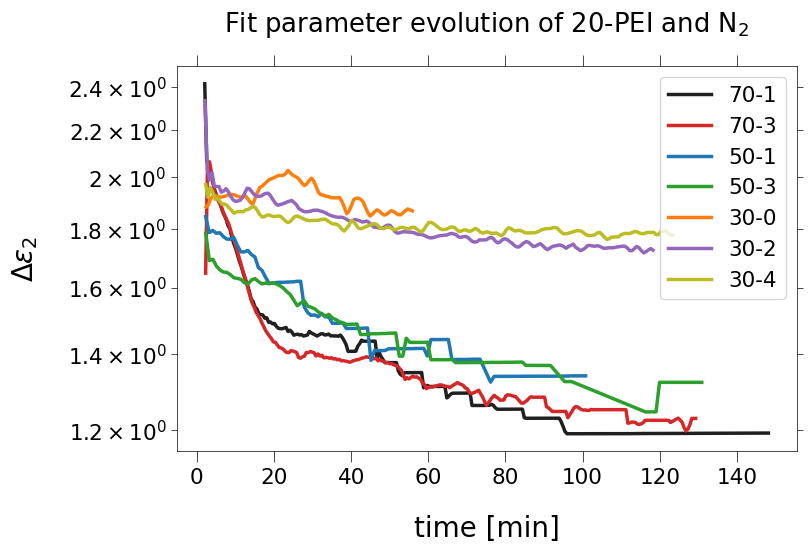

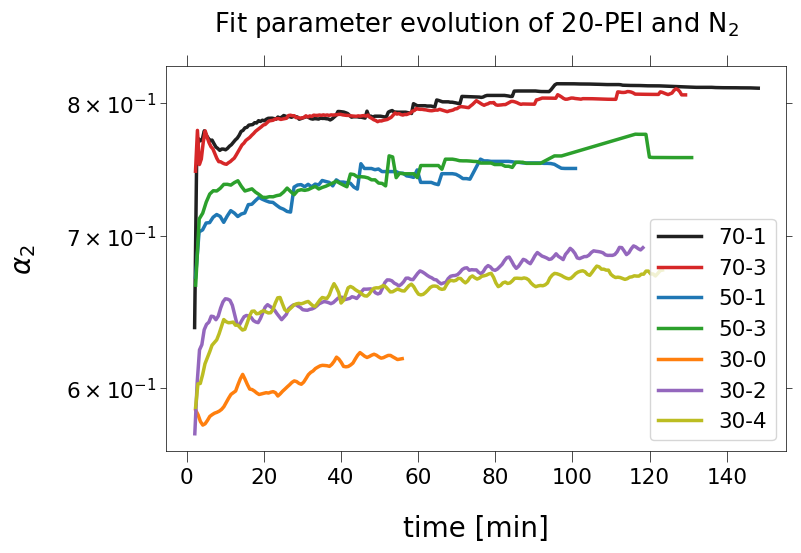

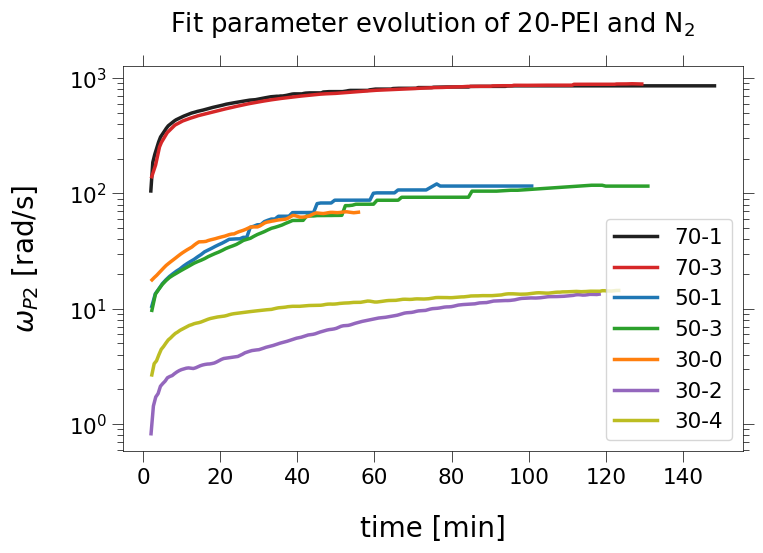

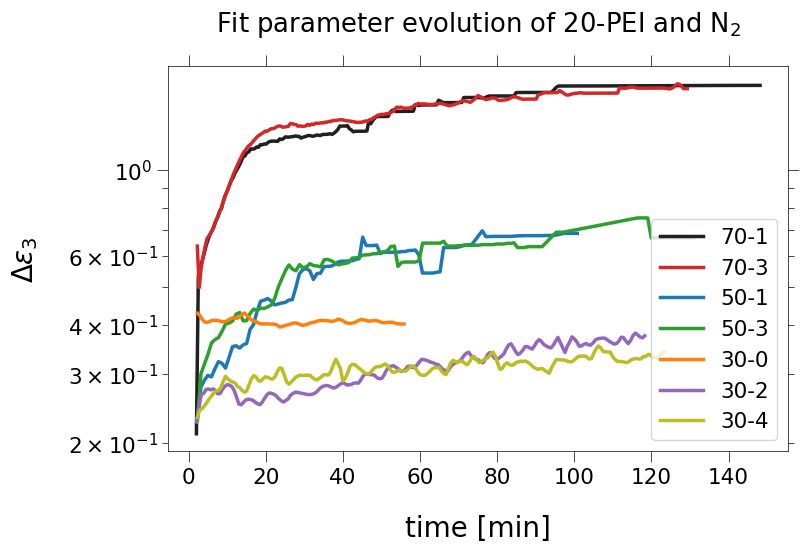

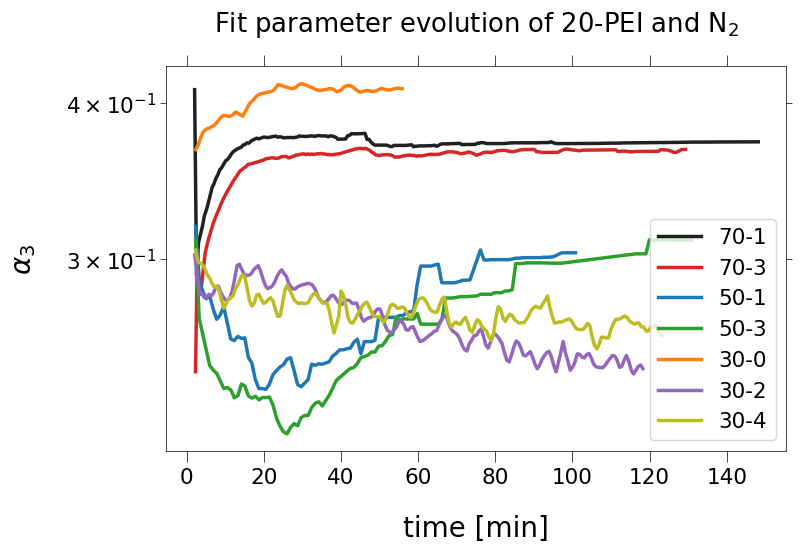

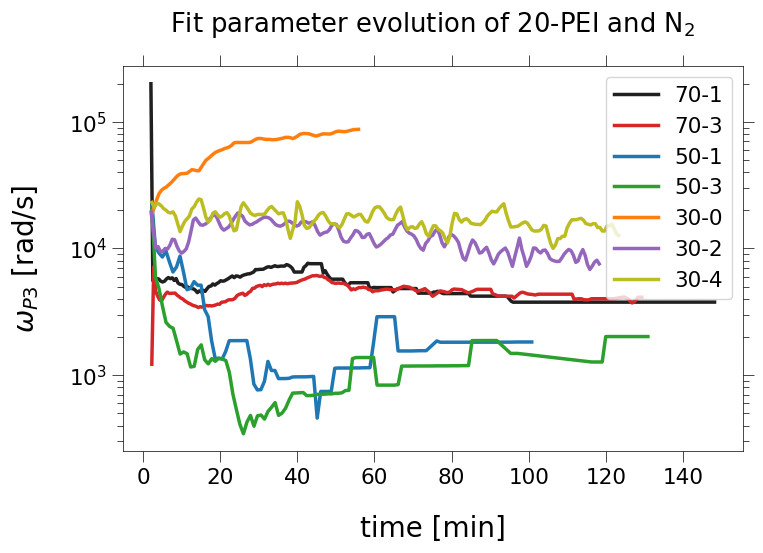

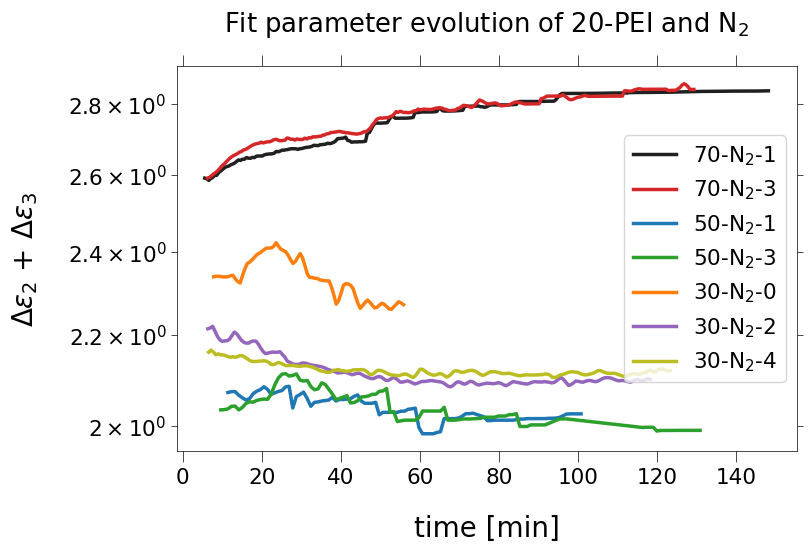

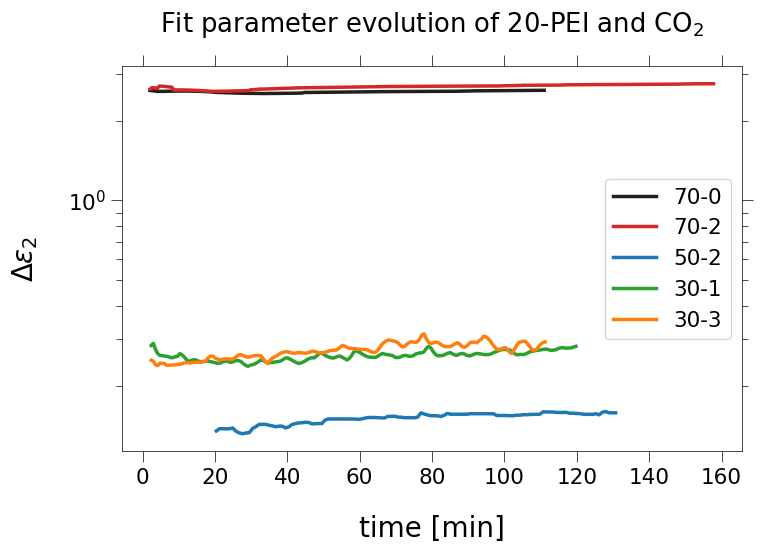

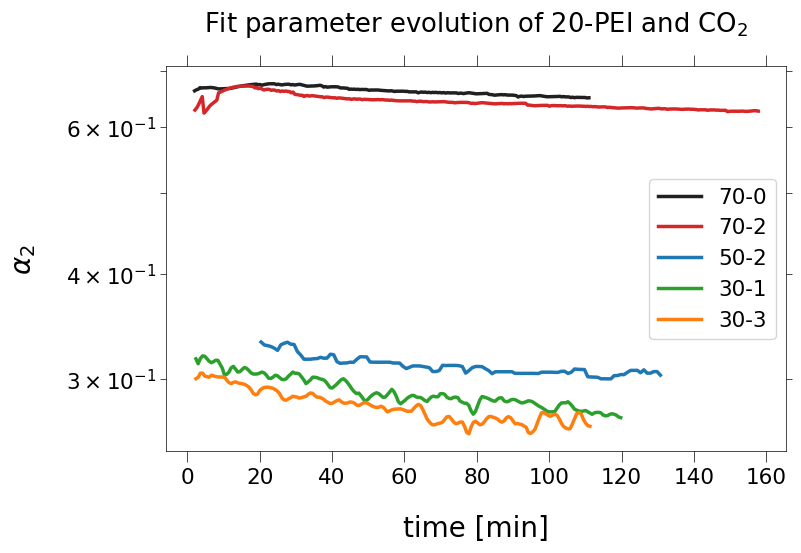

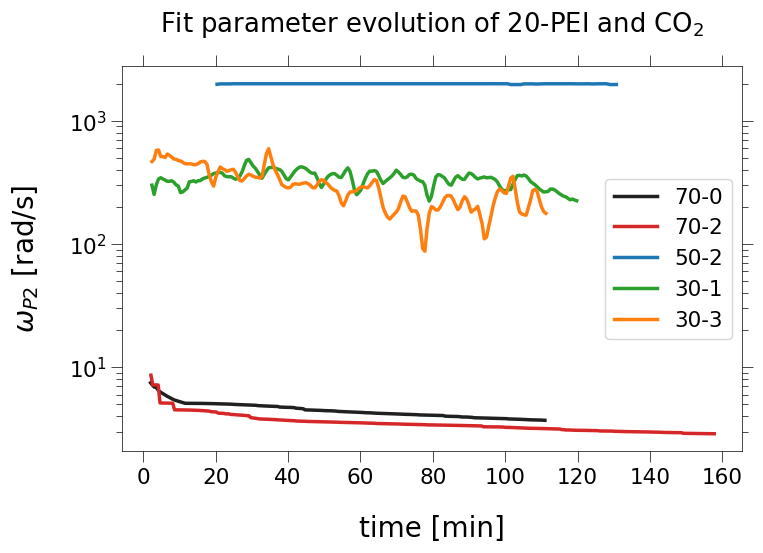

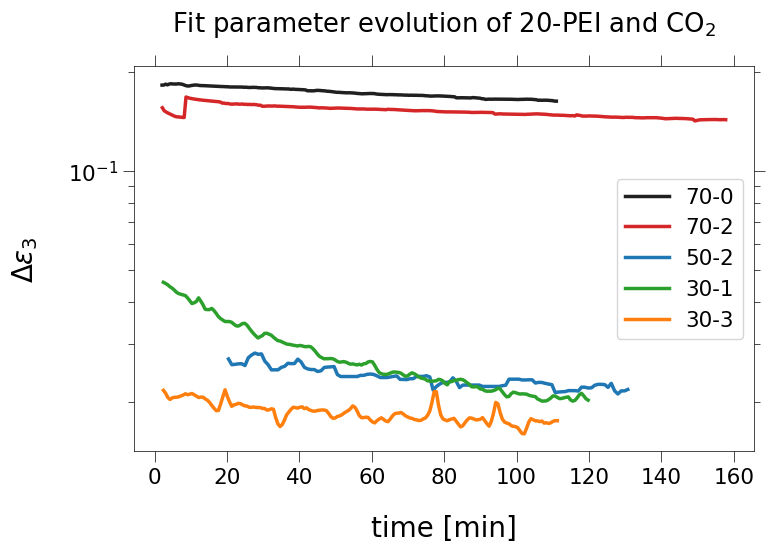

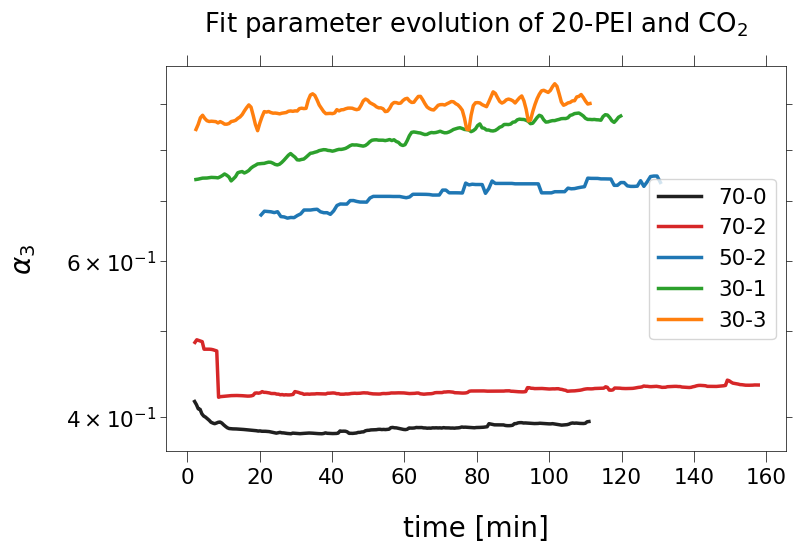

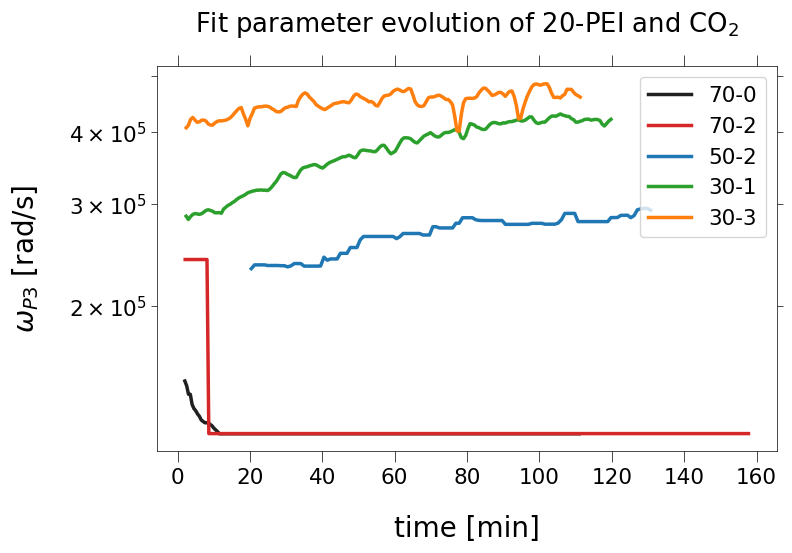

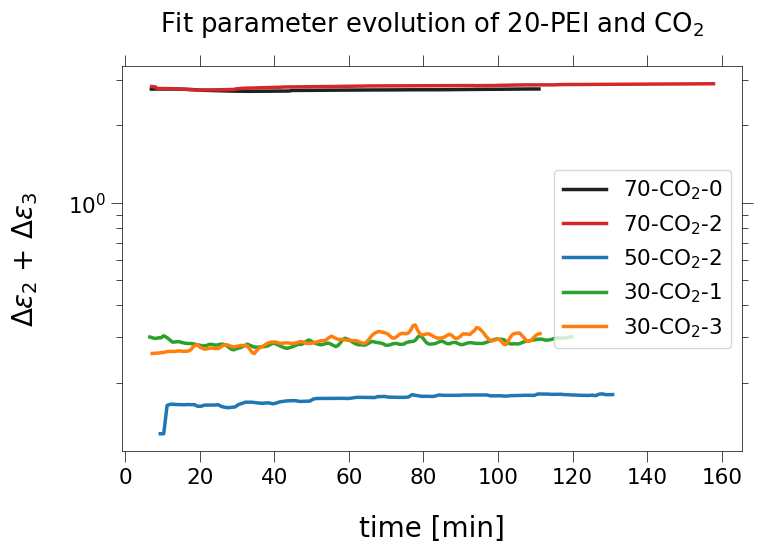

In [ ]:
### Plot time evolution of fit parameters

title_text = "Fit parameter evolution of "+ SAMPLE + " and "

good = [DT_ALL[j] > 2 for j in range(len(DT_ALL))]
DT_ALL_ = [DT_ALL[j][good[j]] for j in range(len(DT_ALL))]
P_ALL_ = [P_ALL[j][:, good[j].flatten()] for j in range(len(DT_ALL))]

# j: run with specific temp and gas
# i: parameters

for gas in GASES :
    for i, parameter in enumerate(p_labels[:-3]) :
        plt.xscale('linear')
        plt.yscale('log')

        #l, u = 1e50, -1

        for j, id in enumerate(ID) :
            if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
                continue
            if id[3] == "C" and id[0] == "5":
                n = 20
            else :
                n = 0
            #if id[0] == "7" and id[-1] == "2" :
            #    continue
            label = id[:2] + id[-2:]

            x, y = DT_ALL_[j][n:], P_ALL_[j][i][n:]
            #lower_threshold, upper_threshold = np.percentile(y, [5, 95])
            #l, u = min(lower_threshold, l), max(upper_threshold, u)

            plt.plot(x, y, label=label, lw=2.5)
            plt.title(title_text + gas)

        plt.xlabel("time [min]")
        plt.ylabel(parameter)
        plt.legend()
        #plt.savefig("results20-2/param/"+gas+" "+parameter[:10]+parameter[-1]+".pdf", bbox_inches='tight')
        plt.show()

    plt.xscale('linear')
    plt.yscale('log')

    for j, id in enumerate(ID) :
        if id[3] != gas[0] :#or (id[0]=='3' and id[-1]=='0') :
            continue
        de_sum = P_ALL[j][0] + P_ALL[j][3]
        plt.plot(DT_ALL[j][10:], de_sum[10:], label=id, lw=2.5)
        plt.title(title_text + gas)

    plt.xlabel("time [min]")
    plt.ylabel(p_labels[0] + " + " + p_labels[3])
    plt.legend()
    plt.show()

[0.86628, 5.2826, 1.1196, 60.631, 0.53422]
[69.568, 0.36558, 1.2648, 16.648, 0.82102]


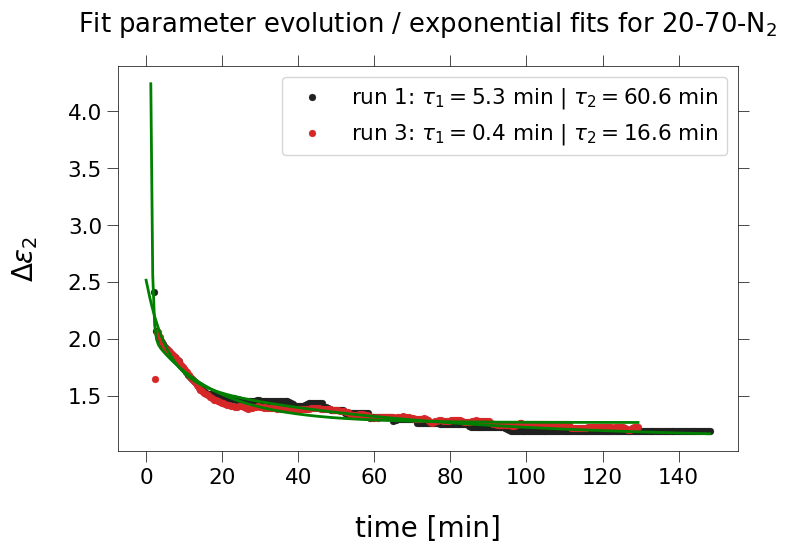

[0.61114, 30.584, 1.3108]
[0.48559, 52.895, 1.2571]


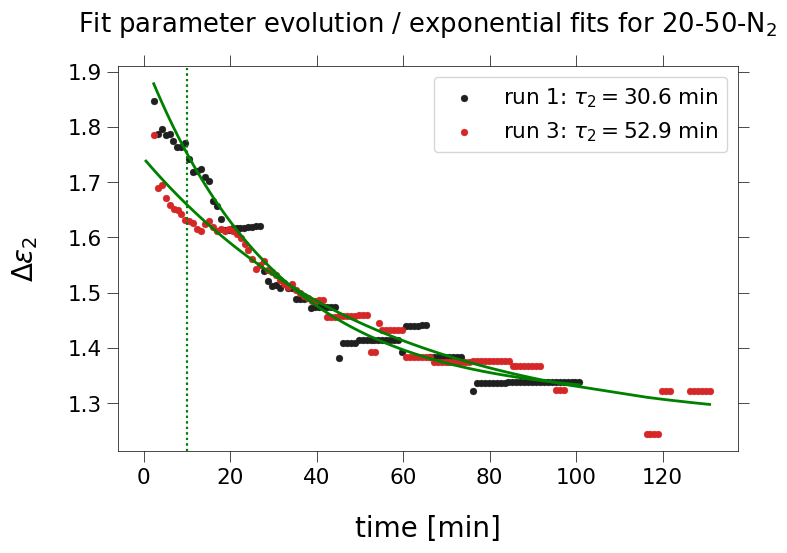

[0.31936, 44.411, 1.702]
[0.12725, 31.747, 1.7816]


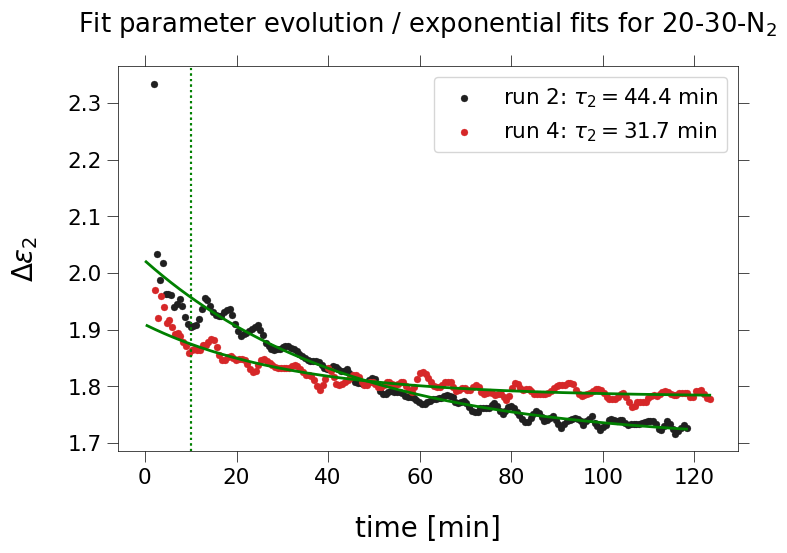

[-0.056928, 66.764, 0.82297]
[-0.051076, 43.749, 0.80908]


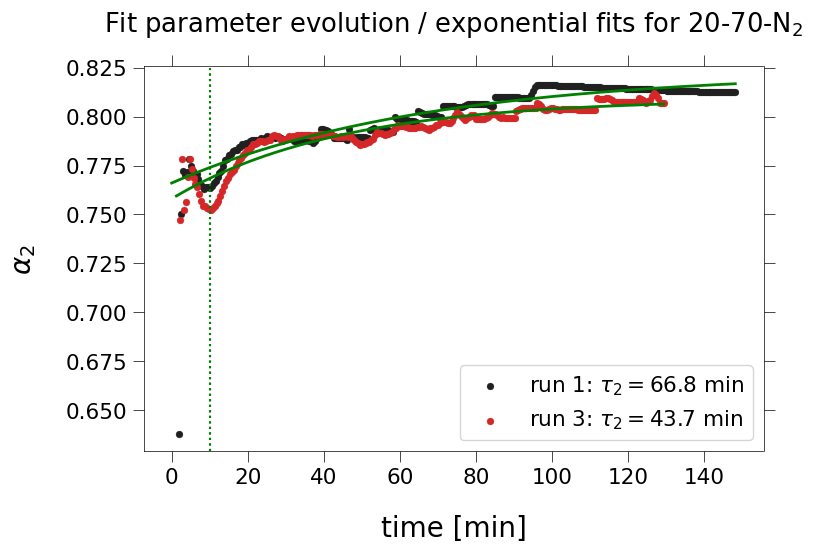

[-0.058325, 30.742, 0.75442]
[-0.063529, 124.04, 0.7864]


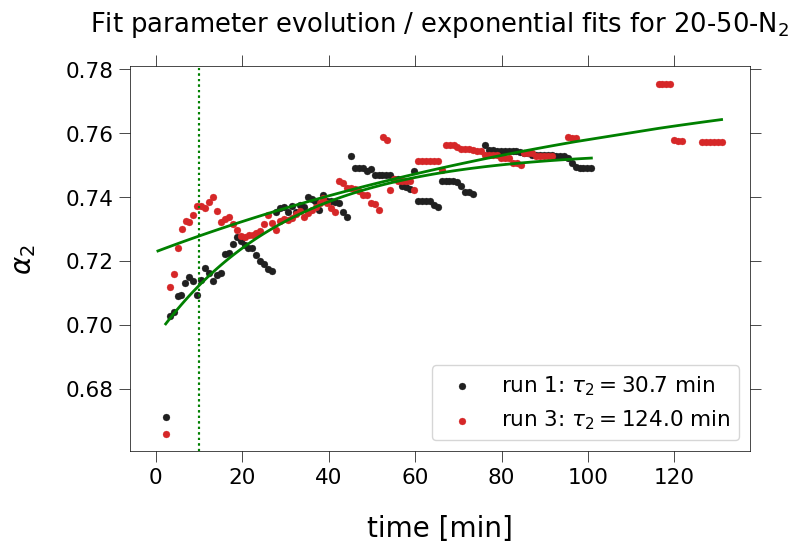

[-0.12042, 178.5, 0.75477]
[-0.046548, 39.104, 0.67545]


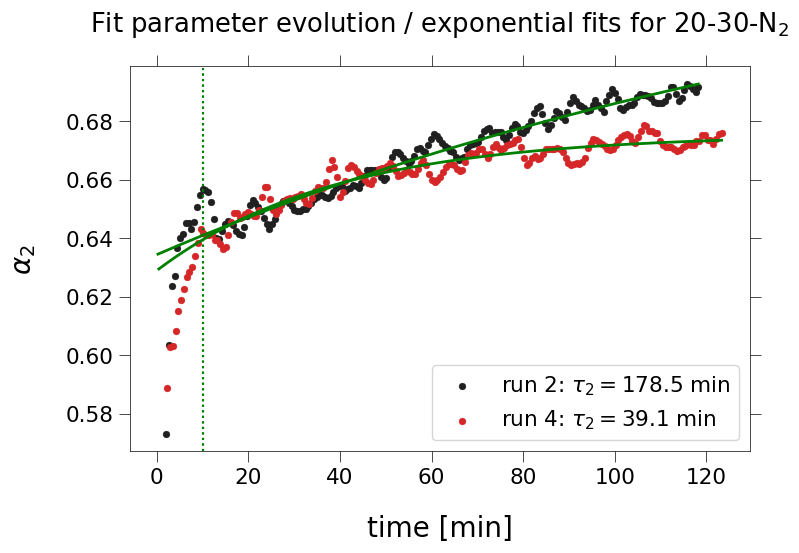

[-353.61, 3.2323, 866.55, 28.993, -566.34]
[-519.57, 2.3636, 910.18, 37.806, -639.78]


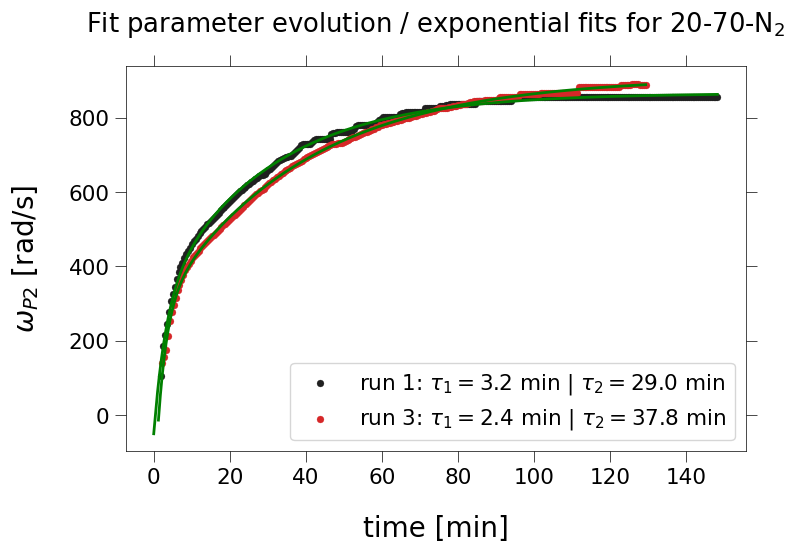

[-183.74, 36.829, 132.47]
[-152.38, 54.131, 131.69]


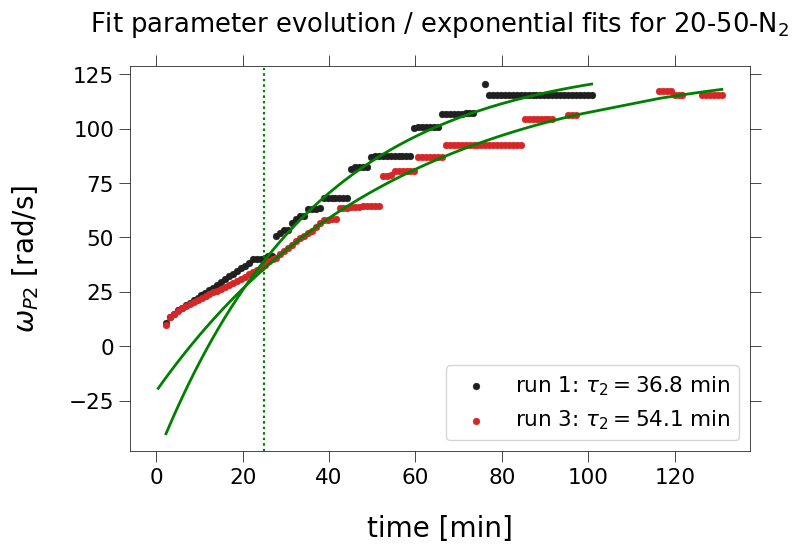

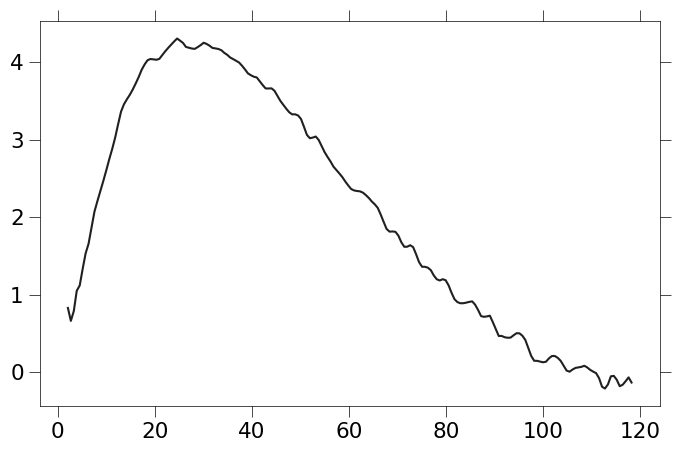

[-6.6165, 8.4609, 21.736, 191.16, -13.893]


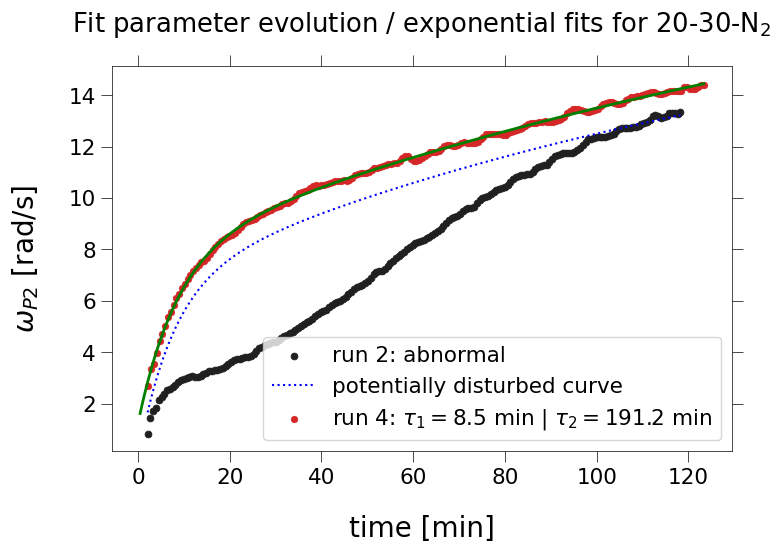

[-0.85143, 4.6468, 1.7434, 55.972, -0.87382]
[-1.1253, 7.0602, 1.9103, 127.03, -0.74635]


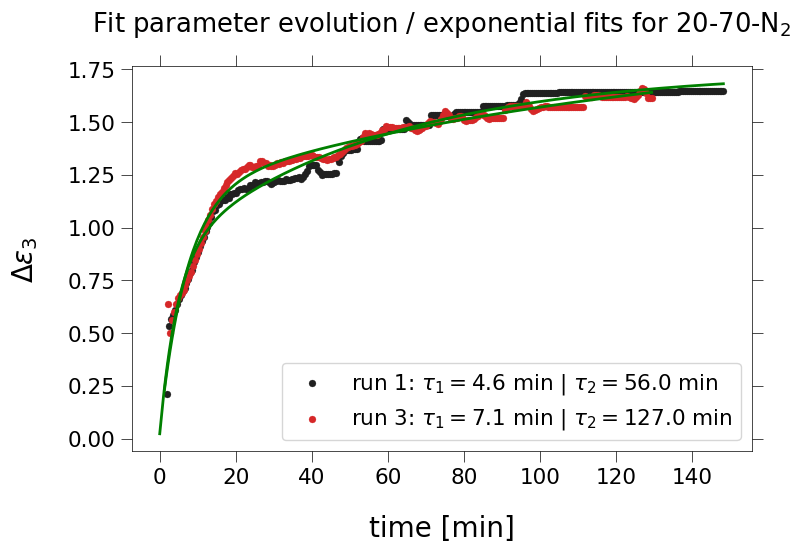

[-0.52785, 25.807, 0.68422]
[-0.40894, 28.646, 0.68087]


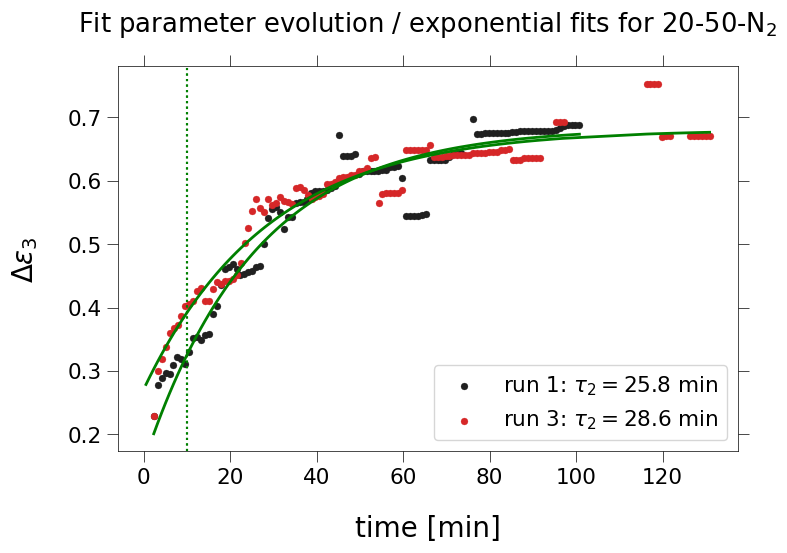

[-0.24519, 93.825, 0.44351]
[-0.08257, 105.78, 0.35895]


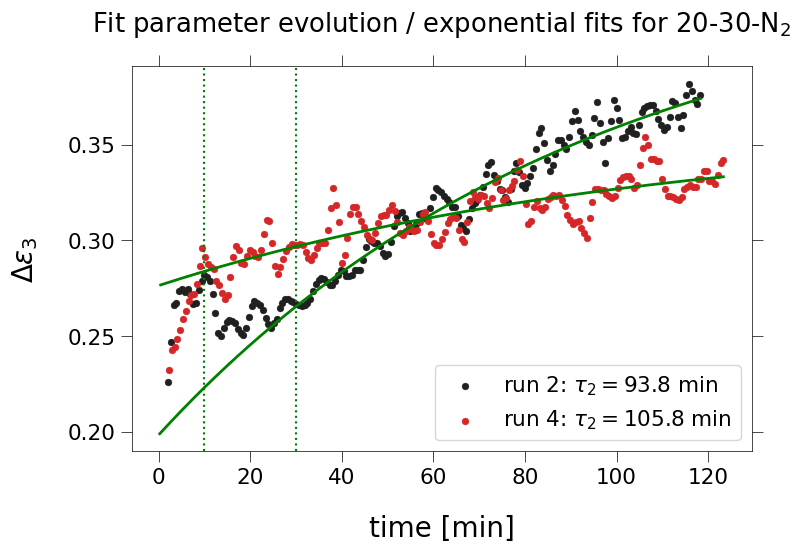

In [ ]:
### parameters by temperature in N2

title_text = "Fit parameter evolution / exponential fits for " + SAMPLE_SHORT +"-"

def exp(x, a, b, c) :
    return a * np.exp(-x/b) + c
def exp2(x, a, b, c, d, e) :
    return a * np.exp(-x/b) + c + e * np.exp(-x/d)

p0_list = [
    [0.8339, 5.2189, 1.2384, 40.091, 0.44262],
    [0.88466, 7.7722, 4.3142e-11, 768.78, 1.4709],
    [0.61185, 32.341, 1.2989],
    [0.47537, 57.774, 1.2508],
    [0.31608, 45.815, 1.6999],
    [0.12895, 31.238, 1.7819],
    [-0.041573, 27.38, 0.80124],
    [-0.042833, 61.915, 0.8071],
    [-0.059169, 34.301, 0.75737],
    [-17.644, 60464.0, 18.371],
    [-0.1303, 202.91, 0.76558],
    [-0.046935, 38.333, 0.67525],
    [-327.95, 2.9828, 845.96, 25.523, -572.6],
    [-597.68, 2.3191, 907.41, 37.63, -624.68],
    [-168.88, 44.715, 138.8],
    [-149.38, 58.953, 134.69],
    [-6.7167, 7.5933, 19.897, 152.68, -12.313],
    [-0.79511, 4.4321, 1.5741, 38.544, -0.75878],
    [-0.84687, 10.533, 2.4398, 334.52, -1.265],
    [-0.50919, 33.138, 0.71171],
    [-0.42379, 23.027, 0.66063],
    [-0.24722, 96.58, 0.44685],
    [-0.081276, 99.864, 0.35672]]

p_i = 0

look_at = [0, 1, 2, 3]
idp_out = ["3022"]
idp_2exp = ["7010", "7030", "7012", "7032", "7013", "7033", "3042"]
start = [0, 0, 5, 5, 5, 5, 5, 5, 10, 10, 25, 25, 0, 0, 30, 0]
s_i = 0

for i in look_at :

    for temperature in TEMPS :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if id[3] != "N" or id[0] != temp[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            title_id = id[:-2]
            label = "run " + id[-1]
            idp = temp + id[-1] + str(i)
            t, p = DT_ALL[j][:], P_ALL[j][i][:]
            cutoff = 100
            pltt = t > 2

            if idp in idp_out :
                label += ": abnormal"
                y2 = exp2(t[pltt], *[-6.717, 7.593, 18.9, 152.7, -12.31])
                plt.plot(t[pltt], y2-p[pltt])
                plt.show()
                plt.scatter(t[pltt], p[pltt], label=label, lw=0.5)
                plt.plot(t[pltt], y2, ls=':', color='b', label='potentially disturbed curve')
                continue

            elif idp not in idp_2exp :
                fitf = exp
                s = max(10, start[s_i])
                fitt2 = (t > s)# & (t < cutoff)
                try :
                    popt2, _ = curve_fit(fitf, t[fitt2], p[fitt2], p0=p0_list[p_i], bounds=((-i_, 0., 0.), (i_, i_, i_)))
                    print([round_sig(pi, 5) for pi in popt2])
                    label += f': $\\tau_2 = ${np.round(popt2[1],1)} min'

                    y2 = fitf(t, *popt2)
                    plt.plot(t, y2, color='g', lw=2)
                except Exception as err :
                    print(str(type(err))[8:-2], ": ", err)

                plt.axvline(s, linestyle=':', color='g')
                s_i += 1
                #plt.axvline(cutoff, linestyle=':', color='g')

            else :
                fitf = exp2
                fitt = t < cutoff
                try :
                    popt, _ = curve_fit(fitf, t, p, p0=p0_list[p_i], bounds=((-i_, 0, 0., 0, -i_), (i_, i_, i_, i_, i_)))
                    print([round_sig(pi, 5) for pi in popt])
                    tau1 = np.round(min(popt[1], popt[3]),1)
                    tau2 = np.round(max(popt[1], popt[3]),1)
                    label += f': $\\tau_1 = ${tau1} min | $\\tau_2 = ${tau2} min'

                    y = fitf(t, *popt)
                    plt.plot(t, y, color='g', lw=2)
                except Exception as err :
                    print(str(type(err))[8:-2], ": ", err)

                #plt.axvline(cutoff, linestyle=':', color='g')

            plt.scatter(t[pltt], p[pltt], label=label, lw=0.2)
            p_i += 1
        
        plt.title(title_text + title_id)
        plt.xlabel("time [min]")
        plt.ylabel(p_labels[i])
        plt.legend()
        #plt.savefig("results20-2/param2/"+gas+" "+temp+".pdf", bbox_inches='tight')
        plt.show()

[-3.4008, 0.82791, 5.5455, 27.735, -1.6895]
[-23.805, 0.61972, 5.5934, 28.724, -1.7238]


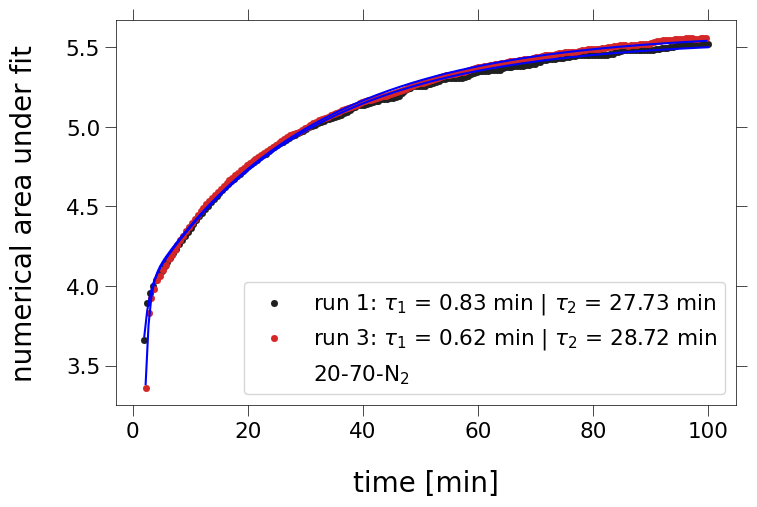

[-0.81674, 2.996, 2.9234, 30.499, -0.76534]
[-1.4643, 1.5164, 2.86, 26.432, -0.90471]


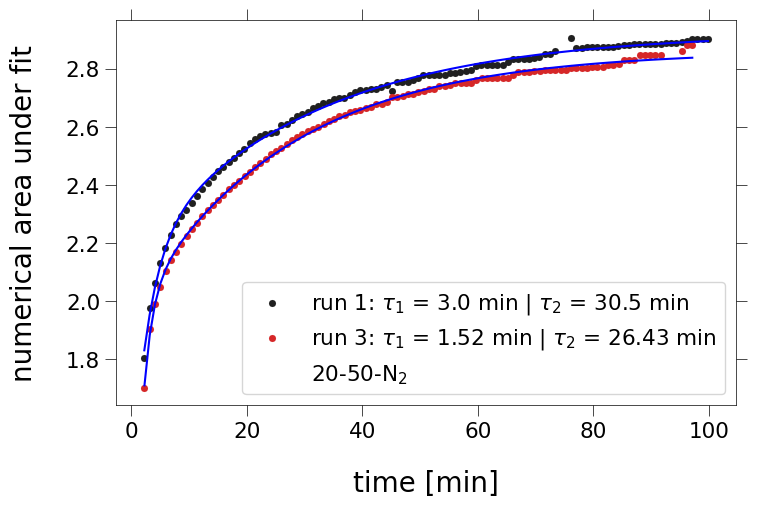

[-0.72161, 5.4982, 2.1612, 80.799, -0.50164]


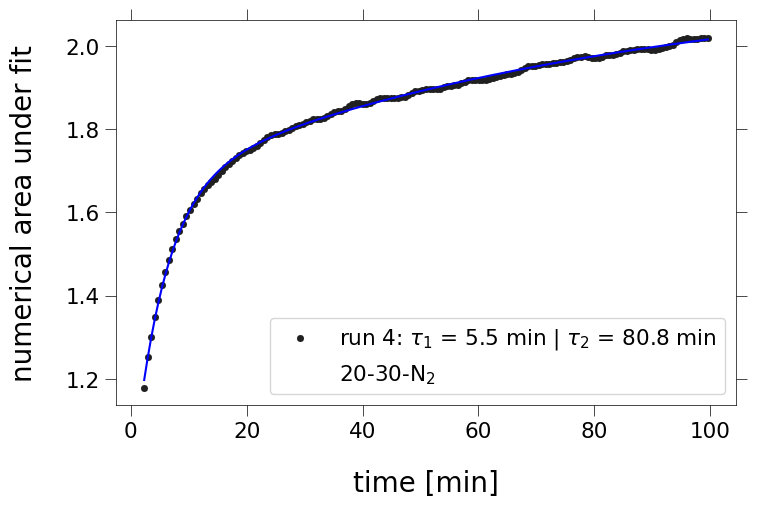

[0.55757, 3.6739, 1.3887, 81.183, 0.36611]
[1.0058, 3.6016, 1.4452, 31.233, 0.18019]


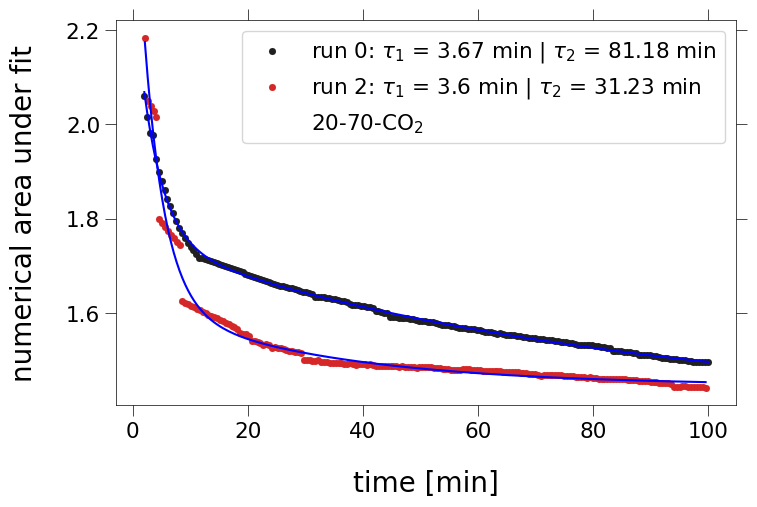

[0.36055, 4.4972, 0.48602, 69.158, -0.004338]


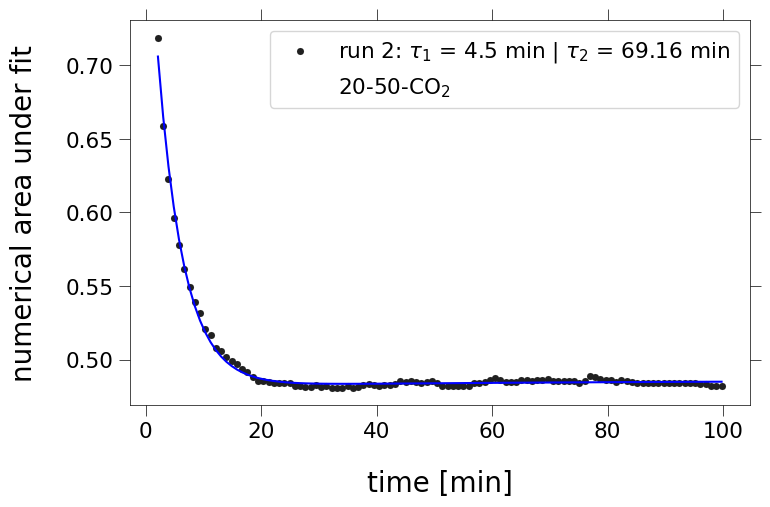

[0.12692, 6.5731, 0.39716, 81.918, 0.06241]
[0.078195, 5.556, 0.39916, 103.52, 0.032849]


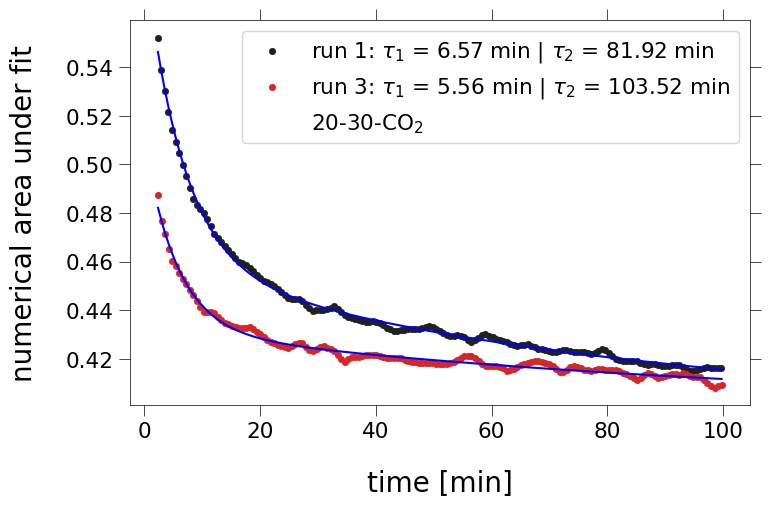

In [ ]:
### Plot area

title_text = "Fit area evolution of "

p01 = [
    [-6.4128, 0.92826, 5.6011, 29.224, -1.6871],
    [-1.1133, 1.7103, 2.8641, 26.753, -0.9038],
    [-0.71593, 5.5692, 2.1664, 82.636, -0.50453]]
p02 = [
    [1.0213, 3.6596, 1.4342, 40.08, 0.17667],
    [0.40282, 3.9605, 0.51474, 2000.0, -0.03151],
    [0.12641, 6.6998, 0.3954, 87.166, 0.063272]]

for gas in GASES :
    for T_i, temperature in enumerate(TEMPS) :
        temp = str(temperature)

        plt.xscale('linear')
        plt.yscale('linear')

        for j, id in enumerate(ID) :
            if not (id[3] == gas[0] and id[0] == temp[0]) or (id[0]=='3' and id[-1] in ['0', '2']) :
                continue
            label0 = "run " + id[-1]
            label_id = SAMPLE_SHORT + '-' + id[:-2]
            t, a = DT_ALL[j], A_ALL[j]
            fitt = (t < 100) & (a < 100) & (t>2)
            t, a = t[fitt], a[fitt]


            if id[3] == "N" :
                p0 = p01[T_i]
            else :
                p0 = p02[T_i]
            try :
                fitf = exp2
                popt, _ = curve_fit(fitf, t, a, p0=p0, bounds=((-i_, 0, 0., 0, -i_), (i_, 20, i_, 2000, i_)))

                tau1 = np.round(popt[1],2)
                tau2 = np.round(popt[3],2)
                label = label0 + f': $\\tau_1$ = {tau1} min | $\\tau_2$ = {tau2} min'

                if tau2 > 500 :
                    fitf = exp
                    popt, _ = curve_fit(fitf, t, a, p0=p0[:3], bounds=((-i_, 0, 0.), (i_, i_, i_)))
                    tau2 = np.round(popt[1],2)
                    label = label0 + f': $\\tau_2$ = {tau2} min'


                print([round_sig(pi, 5) for pi in popt])
                plt.plot(t, fitf(t, *popt), color="b")


                y1 = fitf(t, -i_, *popt[1:])
                y2 = fitf(t, *popt[:-1], -i_)
                #plt.plot(t, y1, linewidth=1, color='b', ls=":")
                #plt.plot(t, y2, linewidth=1, color='g', ls=":")
            except Exception as err :
                print(str(type(err))[8:-2], ": ", err)

            plt.scatter(t, a, label=label, linewidth=0.1)

        plt.plot([],[],color='white',label=label_id)
        plt.xlabel("time [min]")
        plt.ylabel("numerical area under fit")
        plt.legend()
        #plt.savefig("results20-2/area/"+gas+" "+temp+"2.pdf", bbox_inches='tight')
        plt.show()

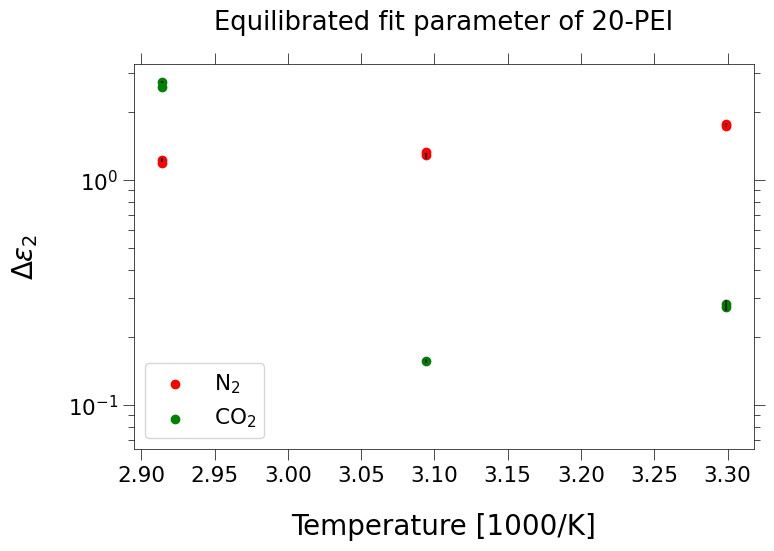

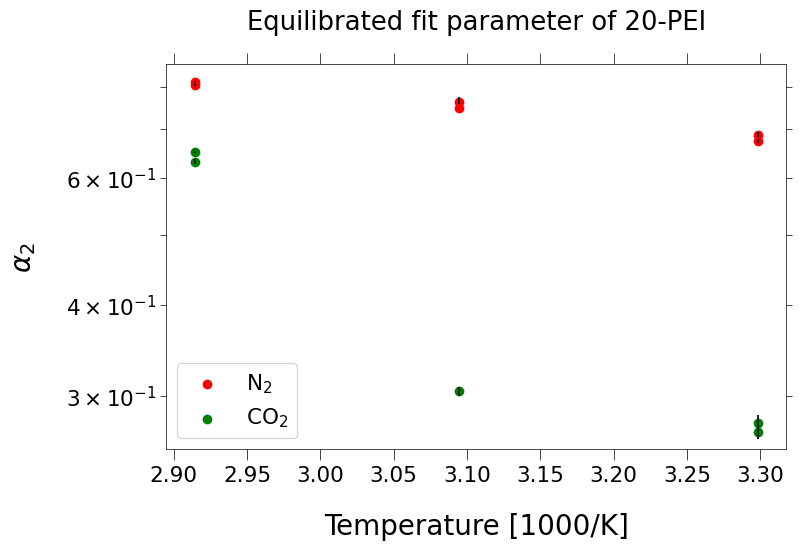

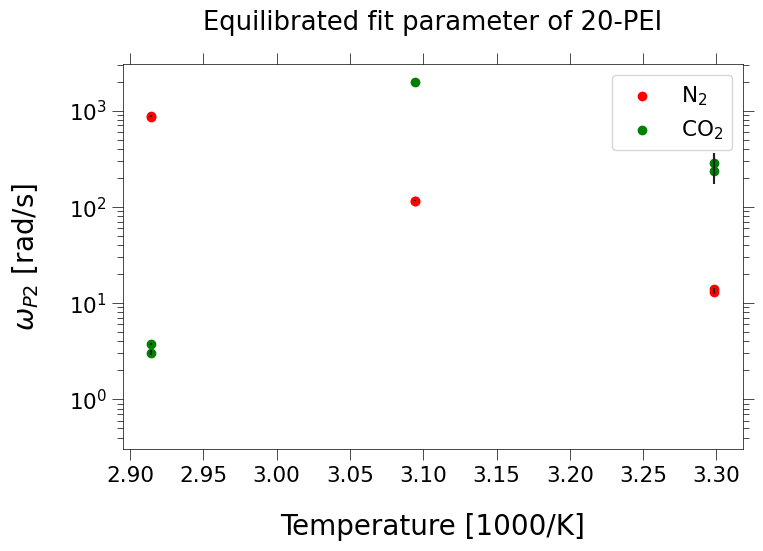

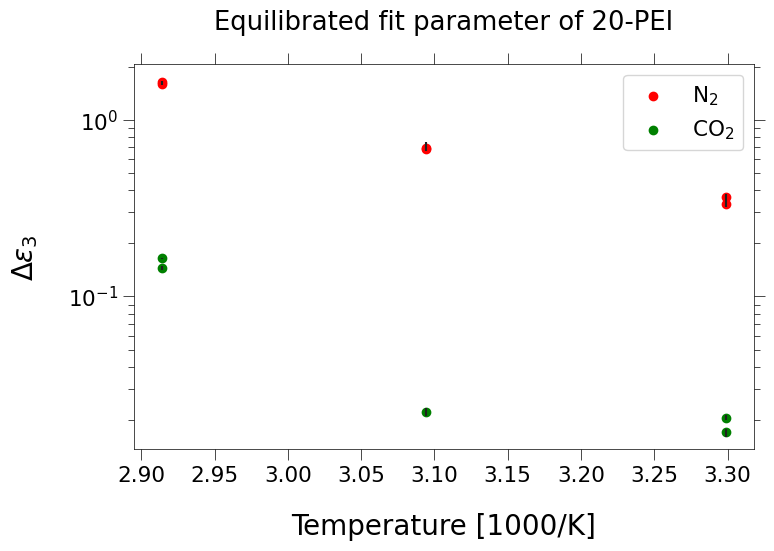

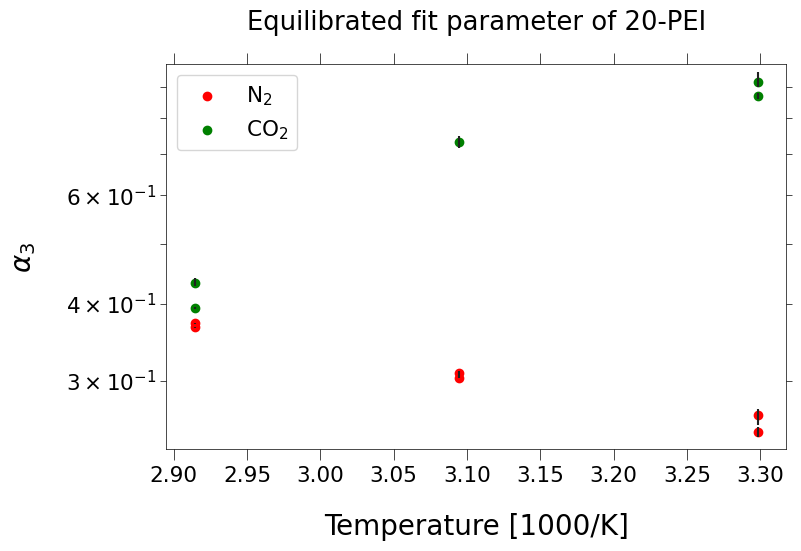

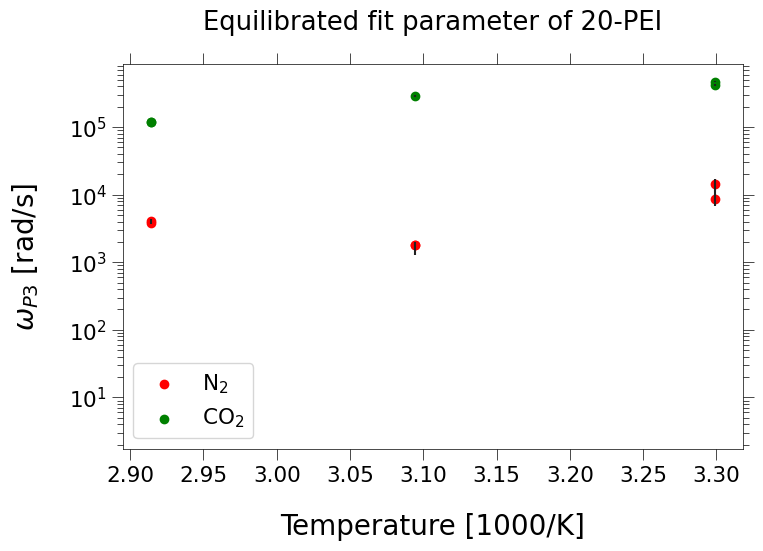

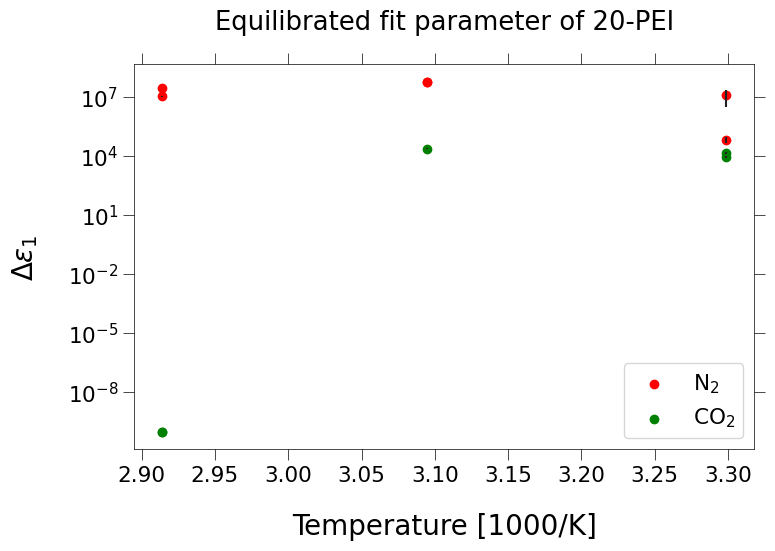

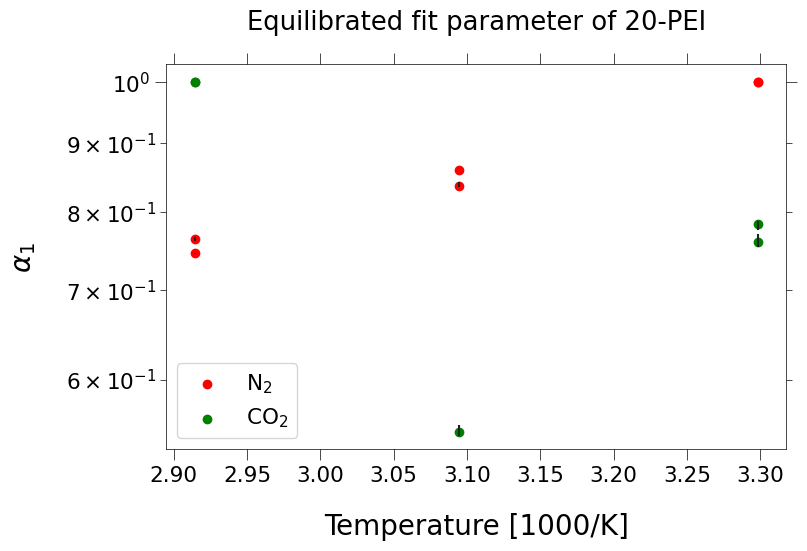

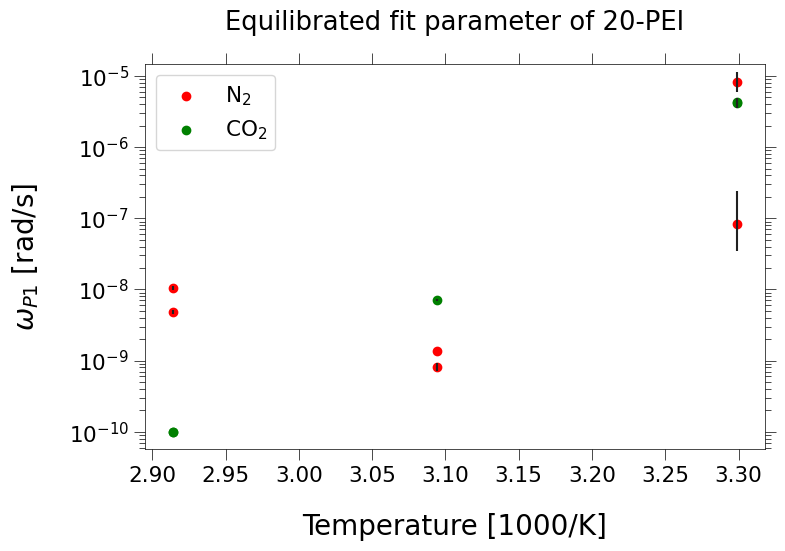

In [ ]:
### plot final fit parameters against temperature
title = "Equilibrated fit parameter of " + SAMPLE
colors = ['red', 'green']

for i, p in enumerate(p_labels) :
    plt.yscale('log')

    for g_i, gas in enumerate(GASES) :
        values = []
        for j, id in enumerate(ID) :
            if not id[3] == gas[0] or (id[0]=='3' and id[-1]=='0') :
                continue
            end = DT_ALL_[j] > 100
            x = P_ALL_[j][i][end]
            xa = np.average(x)
            xe1 = xa - np.min(x)
            xe2 = np.max(x) - xa
            xe1 = xe1 * (xe1 > 0)
            xe2 = xe2 * (xe2 > 0)
            values.append(np.array([int(id[:2]), xa, xe1, xe2]))
        v = np.swapaxes(values, 0, 1)

        T = 1000/(v[0]+273.15)
        plt.scatter(T, v[1], linewidths=2, label=gas, color=colors[g_i])
        plt.errorbar(T, v[1], yerr=v[2:], fmt='none')
        plt.xlabel("Temperature [1000/K]")#"$1/(\\epsilon_0 k_B T)$")

    plt.title(title)
    plt.ylabel(p)
    plt.legend()
    #plt.savefig("results20-2/endval/"+p[:10]+parameter[-1]+".pdf", bbox_inches='tight')
    plt.show()
